In [1]:
import setup_path 
import airsim

import pickle
import time
import os
import sys
import tensorflow as tf
import numpy as np
import math

import matplotlib.pyplot as plt
from src.Agent import DDPGAgent

In [2]:
ACTION_SIZE = 2
STATE_SIZE = 8

TRAINING_EPISODES = 2000

LR_ACTOR = 1e-3
LR_CRITIC = 1e-3

HIDDEN_UNITS = [64, 64]

GAMMA = 0.99
TAU = 6e-2

EPSILON = 1.0
EPSILON_DECAY = 0.9999

MEMORY_SIZE = int(1e6)
BATCH_SIZE = 256

In [3]:
def goStraight(name, client, control):
    state = client.getCarState(name)
    if state.speed < 11.11:
        control.throttle = 1.0
    else:
        control.throttle = 0.70
       
    pos = state.kinematics_estimated.position
    if pos.y_val > 0.01:
        control.steering = -0.0005
    elif pos.y_val < -0.01:
        control.steering = 0.0005
    else:
        control.steering = 0    
    client.setCarControls(control, name)

In [4]:
def toEulerAngle(q):
    #roll (x-axis rotation)
    sinr_cosp = +2.0 * (q.w_val * q.x_val + q.y_val * q.z_val)
    cosr_cosp = +1.0 - 2.0 * (q.x_val * q.x_val + q.y_val * q.y_val)
    roll = math.atan2(sinr_cosp, cosr_cosp)

    #pitch (y-axis rotation)
    sinp = +2.0 * (q.w_val * q.y_val - q.z_val * q.x_val)
    if math.fabs(sinp) >= 1:
        pitch = math.copysign(math.pi / 2, sinp) # use 90 degrees if out of range
    else:
        pitch = math.asin(sinp)

    #yaw (z-axis rotation)
    siny_cosp = +2.0 * (q.w_val * q.z_val + q.x_val * q.y_val)
    cosy_cosp = +1.0 - 2.0 * (q.y_val * q.y_val + q.z_val * q.z_val)
    yaw = math.atan2(siny_cosp, cosy_cosp)
    
    return roll, pitch, yaw

In [5]:
def EnvGetState(client):
    host_state = client.getCarState("Host")
    host_speed = host_state.speed
    host_pos = host_state.kinematics_estimated.position
    host_roll, host_pitch, host_yaw = toEulerAngle(host_state.kinematics_estimated.orientation)
    
    global RX
    global RY
    global RS
    global RYAW
    
    if step % 10 == 0:
        remote_state = client.getCarState("Remote")
        remote_speed = remote_state.speed
        remote_pos = remote_state.kinematics_estimated.position
        remote_roll, remote_pitch, remote_yaw = toEulerAngle(remote_state.kinematics_estimated.orientation)
        
        RX = remote_pos.x_val / 2000.0
        RY = remote_pos.y_val / 20.0
        RS = remote_speed / 30.0
        RYAW = remote_yaw / math.pi

    return np.array([(host_pos.x_val+10) / 2000.0, (host_pos.y_val+3.4) / 20.0, host_speed / 30.0, host_yaw / math.pi, RX, RY, RS, RYAW])    

In [6]:
def EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs):
    #Remote control
    remote_state = client.getCarState("Remote")
    if remote_state.speed < target_speed:
        remote_control.throttle = 1.0
    else:
        remote_control.throttle = 0
        
    if remote_state.kinematics_estimated.position.y_val > 0.01:
        remote_control.steering = -0.0005
    elif remote_state.kinematics_estimated.position.y_val < -0.01:
        remote_control.steering = 0.0005
    else:
        remote_control.steering = 0    
    client.setCarControls(remote_control, "Remote")
    
    #Host control
    host_control.throttle = round((action[0] + 1) / 2, 3)
    host_control.steering = round(action[1] / 2, 3)
    client.setCarControls(host_control, "Host")
    t.append(host_control.throttle)
    s.append(host_control.steering)
    
    
    #####################################################
    client.simPause(False)
    time.sleep(0.01)
    client.simPause(True)
    global step
    step += 1
    #####################################################

    next_state = EnvGetState(client)
    if next_state[6] * 30.0 > 16.67 + 5.55 + 2.0 or next_state[6] * 30.0 <= 0:
        print("Collision error happen")
        sys.exit()
    
    collision_info = client.simGetCollisionInfo()
    if collision_info.has_collided: 
        reward = -3.
        done = True
        flag = 1
        #next_state = np.zeros(8)
        return reward, next_state, done, flag        
        
    flag = 0
    reward = 0    
    done = False
    
    x_val = next_state[0] * 2000.0
    y_val = next_state[1] * 20.0
    speed = next_state[2] * 30.0
    
    remote_state = client.getCarState("Remote")
    remote_y = remote_state.kinematics_estimated.position.y_val
    remote_speed = remote_state.speed

    if remote_speed > 16.67 + 5.55 + 2.0 or remote_speed <= 0.0:
        print("Collision error happen!!")
        sys.exit()
    
    hvs.append(speed)
    rvs.append(remote_speed)

    Ws = 0.0002
    Wl = 0.001
   
    if remote_y < - 0.05 or 0.05 < remote_y:
        reward = -3.
        done = True
        flag = 2
    elif y_val < - 1.7 or 3.4 + 1.7 < y_val:
        reward = -3.
        done = True
        flag = 3
    elif step >= 500:
        if - 0.5 <= y_val and y_val <= 0.5:            
            reward = 1.0
            flag = 7
        else:
            reward = 0.0
            flag = 4       
        done = True
    else:    
        if - 0.5 <= y_val and y_val <= 0.5:            
            reward = 10 * Wl + Ws * speed            
        elif 3.4 - 0.5 <= y_val and y_val <= 3.4 + 0.5:                        
            reward = Wl + Ws * speed
        else:
            reward = Ws * speed

    return reward, next_state, done, flag    

In [5]:
def EnvGetStateForEvalution(client, host_position, remote_position):
    host_state = client.getCarState("Host")
    host_speed = host_state.speed
    host_pos = host_state.kinematics_estimated.position
    host_roll, host_pitch, host_yaw = toEulerAngle(host_state.kinematics_estimated.orientation)
    
    global RX
    global RY
    global RS
    global RYAW
    
    if step % 10 == 0:
        remote_state = client.getCarState("Remote")
        remote_speed = remote_state.speed
        remote_pos = remote_state.kinematics_estimated.position
        remote_roll, remote_pitch, remote_yaw = toEulerAngle(remote_state.kinematics_estimated.orientation)
        
        RX = remote_pos.x_val / 2000.0
        RY = remote_pos.y_val / 20.0
        RS = remote_speed / 30.0
        RYAW = remote_yaw / math.pi

    remote_state = client.getCarState("Remote")    
    remote_pos = remote_state.kinematics_estimated.position        
    host_position.append([host_pos.x_val+10, host_pos.y_val+3.4])
    remote_position.append([remote_pos.x_val, remote_pos.y_val])

    return np.array([(host_pos.x_val+10) / 2000.0, (host_pos.y_val+3.4) / 20.0, host_speed / 30.0, host_yaw / math.pi, RX, RY, RS, RYAW])

In [6]:
def EnvStepForEvaluation(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs, host_position, remote_position):
    #Remote control
    remote_state = client.getCarState("Remote")
    if remote_state.speed < target_speed:
        remote_control.throttle = 1.0
    else:
        remote_control.throttle = 0
        
    if remote_state.kinematics_estimated.position.y_val > 0.01:
        remote_control.steering = -0.0005
    elif remote_state.kinematics_estimated.position.y_val < -0.01:
        remote_control.steering = 0.0005
    else:
        remote_control.steering = 0    
    client.setCarControls(remote_control, "Remote")
    
    #Host control
    host_control.throttle = round((action[0] + 1) / 2, 3)
    host_control.steering = round(action[1] / 2, 3)
    client.setCarControls(host_control, "Host")
    t.append(host_control.throttle)
    s.append(host_control.steering)
    
    
    #####################################################
    client.simPause(False)
    time.sleep(0.01)
    client.simPause(True)
    global step
    step += 1
    #####################################################

    next_state = EnvGetStateForEvalution(client, host_position, remote_position)
    if next_state[6] * 30.0 > 16.67 + 5.55 + 2.0 or next_state[6] * 30.0 <= 0:
        print("Collision error happen")
        sys.exit()
    #First check collision!
    ################################################
    collision_info = client.simGetCollisionInfo()
    if collision_info.has_collided: 
        reward = -3.
        done = True
        flag = 1
        #next_state = np.zeros(8)
        return reward, next_state, done, flag        
    #################################################
    
    flag = 0
    reward = 0    
    done = False
    
    x_val = next_state[0] * 2000.0
    y_val = next_state[1] * 20.0
    speed = next_state[2] * 30.0
    
    remote_state = client.getCarState("Remote")
    remote_y = remote_state.kinematics_estimated.position.y_val
    remote_speed = remote_state.speed

    if remote_speed > 16.67 + 5.55 + 2.0 or remote_speed <= 0.0:
        print("Collision error happen!!")
        sys.exit()
    
    hvs.append(speed)
    rvs.append(remote_speed)

    Ws = 0.0002
    Wl = 0.001
   
    if remote_y < - 0.05 or 0.05 < remote_y:
        reward = -3.
        done = True
        flag = 2
    elif y_val < - 1.7 or 3.4 + 1.7 < y_val:
        reward = -3.
        done = True
        flag = 3
    elif step >= 500:
        if - 0.5 <= y_val and y_val <= 0.5:            
        #if - 0.5 <= y_val and y_val <= 0.5 and speed >= 11.11:            
            reward = 1.0
            #reward = 1.0 + Ws * speed
            flag = 7
        else:
            reward = 0.0
            #reward = 0.0 + Ws * speed
            flag = 4       
        done = True
    else:    
        if - 0.5 <= y_val and y_val <= 0.5:            
            reward = 10 * Wl + Ws * speed            
        elif 3.4 - 0.5 <= y_val and y_val <= 3.4 + 0.5:                        
            reward = Wl + Ws * speed
        else:
            reward = Ws * speed

    return reward, next_state, done, flag    

# Training

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    agent.set_session(sess)    
    agent.hard_update()
    
    for ep in range(1, TRAINING_EPISODES+1):
        #start=time.time()
        #client.reset()
        time.sleep(1)
        step = 0
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)            
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)            

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        #step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)
     
        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)
      
            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 3.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file)  
            break
  
        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

Ep:    1 HV:  6.3 RV: 19.0 Score:  0.867 Average:  0.867 Max: 0.87 F:4 S:   0, Th: 0.50 Steer: -0.03 L: 0.0000, step: 500
Ep:    2 HV:  9.0 RV: 15.6 Score: -2.342 Average: -0.738 Max: 0.87 F:3 S:   0, Th: 0.57 Steer:  0.06 L: 0.0001, step: 276
Ep:    3 HV:  9.5 RV: 14.0 Score: -2.657 Average: -1.377 Max: 0.87 F:3 S:   0, Th: 0.27 Steer:  0.15 L: 0.0112, step: 139
Ep:    4 HV: 10.7 RV: 13.0 Score: -2.789 Average: -1.730 Max: 0.87 F:3 S:   0, Th: 0.17 Steer:  0.28 L: 0.0213, step: 78
Ep:    5 HV: 10.5 RV: 13.1 Score: -2.782 Average: -1.941 Max: 0.87 F:3 S:   0, Th: 0.17 Steer:  0.27 L: 0.0198, step: 82
Ep:    6 HV: 10.2 RV: 12.9 Score: -2.786 Average: -2.082 Max: 0.87 F:3 S:   0, Th: 0.14 Steer:  0.29 L: 0.0134, step: 83
Ep:    7 HV: 10.9 RV: 12.8 Score: -2.813 Average: -2.186 Max: 0.87 F:3 S:   0, Th: 0.20 Steer:  0.37 L: 0.0077, step: 67
Ep:    8 HV: 10.8 RV: 13.0 Score: -2.793 Average: -2.262 Max: 0.87 F:3 S:   0, Th: 0.

Ep:   69 HV: 11.0 RV: 12.9 Score: -2.809 Average: -2.747 Max: 0.87 F:3 S:   0, Th: 0.24 Steer:  0.32 L: 0.0011, step: 69
Ep:   70 HV: 10.9 RV: 12.6 Score: -2.843 Average: -2.748 Max: 0.87 F:3 S:   0, Th: 0.20 Steer:  0.32 L: 0.0016, step: 59
Ep:   71 HV: 10.5 RV: 12.7 Score: -2.812 Average: -2.749 Max: 0.87 F:3 S:   0, Th: 0.18 Steer:  0.30 L: 0.0023, step: 73
Ep:   72 HV: 10.9 RV: 12.6 Score: -2.822 Average: -2.750 Max: 0.87 F:3 S:   0, Th: 0.26 Steer:  0.33 L: 0.0016, step: 65
Ep:   73 HV: 10.7 RV: 12.6 Score: -2.828 Average: -2.751 Max: 0.87 F:3 S:   0, Th: 0.22 Steer:  0.34 L: 0.0015, step: 64
Ep:   74 HV: 10.8 RV: 12.6 Score: -2.830 Average: -2.752 Max: 0.87 F:3 S:   0, Th: 0.18 Steer:  0.36 L: 0.0017, step: 63
Ep:   75 HV: 10.5 RV: 12.7 Score: -2.805 Average: -2.753 Max: 0.87 F:3 S:   0, Th: 0.16 Steer:  0.28 L: 0.0014, step: 74
Ep:   76 HV: 10.6 RV: 12.7 Score: -2.811 Average: -2.754 Max: 0.87 F:3 S:   0, Th: 0.16 Steer:  0.31 L: 0.0012, step: 71
Ep:   77 HV: 10.6 RV: 12.8 Score

Ep:  137 HV:  4.1 RV: 17.8 Score:  0.797 Average: -2.650 Max: 0.87 F:4 S:   0, Th: 0.27 Steer:  0.02 L: 0.0031, step: 500
Ep:  138 HV:  4.0 RV: 18.0 Score:  0.523 Average: -2.616 Max: 0.87 F:4 S:   0, Th: 0.28 Steer:  0.00 L: 0.0037, step: 500
Ep:  139 HV:  9.8 RV: 13.3 Score: -2.759 Average: -2.616 Max: 0.87 F:1 S:   0, Th: 0.18 Steer: -0.12 L: 0.0036, step: 104
Ep:  140 HV:  8.9 RV: 14.0 Score: -2.682 Average: -2.614 Max: 0.87 F:1 S:   0, Th: 0.22 Steer: -0.15 L: 0.0104, step: 141
Ep:  141 HV: 10.0 RV: 13.5 Score: -2.744 Average: -2.613 Max: 0.87 F:1 S:   0, Th: 0.17 Steer: -0.23 L: 0.0097, step: 106
Ep:  142 HV:  9.9 RV: 13.3 Score: -2.740 Average: -2.613 Max: 0.87 F:1 S:   0, Th: 0.22 Steer: -0.26 L: 0.0123, step: 101
Ep:  143 HV: 10.0 RV: 13.4 Score: -2.753 Average: -2.612 Max: 0.87 F:1 S:   0, Th: 0.18 Steer: -0.29 L: 0.0185, step: 102
Ep:  144 HV: 10.0 RV: 13.4 Score: -2.650 Average: -2.610 Max: 0.87 F:1 S:   0, Th: 0.18 Steer: -0.28 L: 0.0238, step: 99
Ep:  145 HV: 10.0 RV: 13.

SystemExit: 

C:\Users\Lab\Anaconda3\envs\airsim\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 147

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 146
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)
    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)

        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 2.5:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-146
memory: 15934, total_scores: 146, success: 0
Ep:  147 HV:  9.8 RV: 13.3 Score: -2.755 Average: -2.608 Max: 0.87 F:1 S:   0, Th: 0.21 Steer: -0.32 L: 0.0125, step: 101
Ep:  148 HV:  9.8 RV: 13.2 Score: -2.687 Average: -2.607 Max: 0.87 F:1 S:   0, Th: 0.19 Steer: -0.31 L: 0.0136, step: 99
Ep:  149 HV:  9.9 RV: 13.2 Score: -2.692 Average: -2.606 Max: 0.87 F:1 S:   0, Th: 0.19 Steer: -0.30 L: 0.0130, step: 100
Ep:  150 HV: 10.0 RV: 13.4 Score: -2.740 Average: -2.605 Max: 0.87 F:1 S:   0, Th: 0.22 Steer: -0.29 L: 0.0120, step: 101
Ep:  151 HV: 10.0 RV: 13.5 Score: -2.750 Average: -2.604 Max: 0.87 F:1 S:   0, Th: 0.26 Steer: -0.30 L: 0.0083, step: 103
Ep:  152 HV:  9.8 RV: 13.2 Score: -2.709 Average: -2.603 Max: 0.87 F:1 S:   0, Th: 0.21 Steer: -0.29 L: 0.0081, step: 99
Ep:  153 HV:  9.7 RV: 13.2 Score: -2.762 Average: -2.602 Max: 0.87 F:1 S:   0, Th: 0.17 Steer: -

SystemExit: 

C:\Users\Lab\Anaconda3\envs\airsim\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 171

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 170
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)
    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))

    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)
      
        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)
      
            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 2.5:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-170
memory: 20574, total_scores: 170, success: 0
Ep:  171 HV: 15.9 RV: 17.1 Score: -1.707 Average: -2.401 Max: 1.96 F:1 S:   0, Th: 0.82 Steer: -0.01 L: 0.0045, step: 322
Ep:  172 HV: 12.8 RV: 15.2 Score: -2.402 Average: -2.397 Max: 1.96 F:1 S:   0, Th: 0.80 Steer: -0.01 L: 0.0044, step: 216
Ep:  173 HV: 13.0 RV: 15.5 Score: -2.206 Average: -2.391 Max: 1.96 F:1 S:   0, Th: 0.80 Steer: -0.01 L: 0.0044, step: 284
Ep:  174 HV: 13.5 RV: 15.9 Score: -2.349 Average: -2.386 Max: 1.96 F:1 S:   0, Th: 0.82 Steer:  0.05 L: 0.0044, step: 229
Ep:  175 HV: 13.8 RV: 19.0 Score:  1.494 Average: -2.343 Max: 1.96 F:4 S:   0, Th: 0.78 Steer: -0.01 L: 0.0043, step: 500
Collision error happen!!


SystemExit: 

C:\Users\Lab\Anaconda3\envs\airsim\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 176

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 175
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)
    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))

    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)

        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)
    
            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 2.5:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-175
memory: 22125, total_scores: 175, success: 0
Ep:  176 HV: 13.1 RV: 15.4 Score: -2.383 Average: -2.339 Max: 1.96 F:2 S:   0, Th: 0.83 Steer: -0.01 L: 0.0042, step: 208
Ep:  177 HV: 15.2 RV: 16.5 Score: -1.575 Average: -2.327 Max: 1.96 F:1 S:   0, Th: 0.83 Steer: -0.01 L: 0.0042, step: 273
Ep:  178 HV: 12.0 RV: 14.9 Score: -2.491 Average: -2.323 Max: 1.96 F:1 S:   0, Th: 0.79 Steer:  0.01 L: 0.0042, step: 175
Ep:  179 HV: 14.7 RV: 16.1 Score: -1.811 Average: -2.313 Max: 1.96 F:1 S:   0, Th: 0.81 Steer: -0.01 L: 0.0043, step: 246
Ep:  180 HV: 13.9 RV: 18.5 Score:  2.346 Average: -2.262 Max: 2.35 F:4 S:   0, Th: 0.82 Steer:  0.02 L: 0.0048, step: 500
Ep:  181 HV: 12.4 RV: 15.6 Score: -2.348 Average: -2.257 Max: 2.35 F:1 S:   0, Th: 0.79 Steer: -0.04 L: 0.0047, step: 214
Ep:  182 HV: 12.2 RV: 14.6 Score: -2.562 Average: -2.254 Max: 2.35 F:1 S:   0, Th: 0.81 Steer:

SystemExit: 

C:\Users\Lab\Anaconda3\envs\airsim\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 185

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 184
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)
    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))

    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)
    
        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)
     
            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 2.5:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-184
memory: 24585, total_scores: 184, success: 0
Ep:  185 HV: 12.8 RV: 14.9 Score: -2.504 Average: -2.187 Max: 3.27 F:1 S:   0, Th: 0.81 Steer: -0.02 L: 0.0054, step: 178
Ep:  186 HV: 13.2 RV: 15.6 Score: -2.332 Average: -2.182 Max: 3.27 F:1 S:   0, Th: 0.80 Steer: -0.03 L: 0.0048, step: 215
Ep:  187 HV: 12.7 RV: 15.1 Score: -2.461 Average: -2.178 Max: 3.27 F:1 S:   0, Th: 0.80 Steer: -0.06 L: 0.0046, step: 189
Ep:  188 HV: 12.7 RV: 15.5 Score: -2.413 Average: -2.175 Max: 3.27 F:1 S:   0, Th: 0.79 Steer: -0.02 L: 0.0058, step: 209
Ep:  189 HV: 12.6 RV: 15.2 Score: -2.452 Average: -2.171 Max: 3.27 F:1 S:   0, Th: 0.82 Steer:  0.00 L: 0.0056, step: 194
Collision error happen!!


SystemExit: 

C:\Users\Lab\Anaconda3\envs\airsim\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 190 

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 189
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)
    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)
 
        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)
     
            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 2.5:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-189
memory: 25570, total_scores: 189, success: 0
Ep:  190 HV: 12.5 RV: 14.7 Score: -2.531 Average: -2.169 Max: 3.27 F:1 S:   0, Th: 0.79 Steer: -0.03 L: 0.0054, step: 165
Ep:  191 HV: 12.6 RV: 15.4 Score: -2.208 Average: -2.163 Max: 3.27 F:1 S:   0, Th: 0.79 Steer: -0.02 L: 0.0062, step: 253
Ep:  192 HV: 13.7 RV: 15.6 Score: -2.639 Average: -2.161 Max: 3.27 F:2 S:   0, Th: 0.84 Steer: -0.02 L: 0.0052, step: 124
Ep:  193 HV: 13.6 RV: 16.4 Score: -2.495 Average: -2.158 Max: 3.27 F:1 S:   0, Th: 0.81 Steer: -0.02 L: 0.0065, step: 172
Ep:  194 HV: 12.2 RV: 14.6 Score: -2.531 Average: -2.156 Max: 3.27 F:2 S:   0, Th: 0.80 Steer: -0.00 L: 0.0056, step: 164
Ep:  195 HV: 12.4 RV: 14.8 Score: -2.525 Average: -2.153 Max: 3.27 F:2 S:   0, Th: 0.79 Steer:  0.02 L: 0.0062, step: 169
Ep:  196 HV: 12.2 RV: 15.3 Score: -2.424 Average: -2.149 Max: 3.27 F:1 S:   0, Th: 0.80 Steer:

SystemExit: 

C:\Users\Lab\Anaconda3\envs\airsim\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 215 

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 214
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:

    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)
    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))

    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)
  
        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)
   
            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 2.5:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-214
memory: 31273, total_scores: 214, success: 2
Ep:  215 HV: 13.4 RV: 18.6 Score:  3.496 Average: -1.844 Max: 3.74 F:7 S:   3, Th: 0.79 Steer: -0.00 L: 0.0065, step: 500
Ep:  216 HV: 14.6 RV: 18.5 Score:  2.762 Average: -1.789 Max: 3.74 F:7 S:   4, Th: 0.80 Steer: -0.01 L: 0.0071, step: 500
Ep:  217 HV: 13.4 RV: 18.9 Score:  2.065 Average: -1.742 Max: 3.74 F:4 S:   4, Th: 0.80 Steer:  0.00 L: 0.0073, step: 500
Ep:  218 HV: 14.3 RV: 18.3 Score:  1.573 Average: -1.700 Max: 3.74 F:4 S:   4, Th: 0.79 Steer: -0.01 L: 0.0069, step: 500
Ep:  219 HV: 12.9 RV: 18.8 Score:  3.297 Average: -1.641 Max: 3.74 F:7 S:   5, Th: 0.80 Steer:  0.00 L: 0.0075, step: 500
Ep:  220 HV: 12.6 RV: 15.4 Score: -2.384 Average: -1.639 Max: 3.74 F:1 S:   5, Th: 0.79 Steer: -0.01 L: 0.0069, step: 216
Ep:  221 HV: 13.6 RV: 17.0 Score:  1.749 Average: -1.595 Max: 3.74 F:4 S:   5, Th: 0.79 Steer:

Ep:  281 HV: 10.2 RV: 18.8 Score: -1.134 Average:  0.102 Max: 3.74 F:3 S:  14, Th: 0.73 Steer: -0.02 L: 0.0063, step: 477
Ep:  282 HV: 11.8 RV: 15.2 Score: -2.337 Average:  0.104 Max: 3.74 F:1 S:  14, Th: 0.58 Steer: -0.03 L: 0.0055, step: 238
Ep:  283 HV: 10.7 RV: 18.3 Score:  1.892 Average:  0.148 Max: 3.74 F:4 S:  14, Th: 0.70 Steer: -0.01 L: 0.0061, step: 500
Ep:  284 HV: 12.5 RV: 15.3 Score: -2.373 Average:  0.091 Max: 3.74 F:1 S:  14, Th: 0.63 Steer: -0.02 L: 0.0069, step: 210
Ep:  285 HV: 11.9 RV: 17.3 Score:  2.328 Average:  0.140 Max: 3.74 F:4 S:  14, Th: 0.74 Steer: -0.02 L: 0.0068, step: 500
Ep:  286 HV: 10.3 RV: 15.8 Score:  1.967 Average:  0.183 Max: 3.74 F:4 S:  14, Th: 0.69 Steer: -0.01 L: 0.0071, step: 500
Ep:  287 HV:  9.6 RV: 17.9 Score: -1.394 Average:  0.193 Max: 3.74 F:3 S:  14, Th: 0.65 Steer: -0.02 L: 0.0068, step: 470
Ep:  288 HV: 10.3 RV: 17.3 Score:  1.862 Average:  0.236 Max: 3.74 F:4 S:  14, Th: 0.72 Steer: -0.01 L: 0.0067, step: 500
Ep:  289 HV:  8.6 RV: 16

Ep:  349 HV:  9.5 RV: 18.9 Score:  1.735 Average:  1.142 Max: 3.74 F:4 S:  24, Th: 0.68 Steer:  0.00 L: 0.0055, step: 500
Ep:  350 HV: 10.0 RV: 18.4 Score: -1.293 Average:  1.118 Max: 3.74 F:3 S:  24, Th: 0.67 Steer:  0.01 L: 0.0043, step: 465
Ep:  351 HV: 10.7 RV: 18.3 Score:  2.138 Average:  1.128 Max: 3.74 F:4 S:  24, Th: 0.66 Steer: -0.02 L: 0.0048, step: 500
Ep:  352 HV:  9.6 RV: 19.1 Score:  1.819 Average:  1.121 Max: 3.74 F:4 S:  24, Th: 0.69 Steer: -0.01 L: 0.0043, step: 500
Ep:  353 HV:  9.7 RV: 18.1 Score:  2.850 Average:  1.130 Max: 3.74 F:4 S:  24, Th: 0.65 Steer:  0.00 L: 0.0055, step: 500
Ep:  354 HV:  9.7 RV: 18.0 Score:  2.464 Average:  1.169 Max: 3.74 F:4 S:  24, Th: 0.70 Steer:  0.01 L: 0.0051, step: 500
Ep:  355 HV:  9.7 RV: 19.0 Score:  1.768 Average:  1.176 Max: 3.74 F:4 S:  24, Th: 0.67 Steer: -0.03 L: 0.0045, step: 500
Ep:  356 HV:  9.2 RV: 17.2 Score:  2.937 Average:  1.178 Max: 3.74 F:7 S:  25, Th: 0.67 Steer: -0.00 L: 0.0053, step: 500
Ep:  357 HV:  9.3 RV: 17

SystemExit: 

C:\Users\Lab\Anaconda3\envs\airsim\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 402

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-401
memory: 120443, total_scores: 401, success: 44
Ep:  402 HV: 11.9 RV: 18.7 Score:  1.972 Average:  1.984 Max: 4.27 F:4 S:  44, Th: 0.77 Steer: -0.00 L: 0.0043, step: 500
Ep:  403 HV: 10.9 RV: 18.9 Score:  2.177 Average:  1.992 Max: 4.27 F:4 S:  44, Th: 0.71 Steer: -0.01 L: 0.0033, step: 500
Ep:  404 HV: 11.3 RV: 16.3 Score:  3.047 Average:  2.003 Max: 4.27 F:7 S:  45, Th: 0.72 Steer:  0.01 L: 0.0038, step: 500
Ep:  405 HV: 12.4 RV: 18.0 Score:  1.531 Average:  1.990 Max: 4.27 F:4 S:  45, Th: 0.75 Steer: -0.02 L: 0.0042, step: 500
Ep:  406 HV: 10.3 RV: 15.9 Score:  4.148 Average:  2.002 Max: 4.27 F:7 S:  46, Th: 0.67 Steer: -0.02 L: 0.0045, step: 500
Ep:  407 HV: 11.0 RV: 16.4 Score:  2.548 Average:  2.014 Max: 4.27 F:4 S:  46, Th: 0.71 Steer: -0.01 L: 0.0047, step: 500
Ep:  408 HV: 10.1 RV: 18.0 Score:  4.267 Average:  2.037 Max: 4.27 F:7 S:  47, Th: 0.68 Stee

Ep:  468 HV:  8.1 RV: 17.1 Score:  1.057 Average:  1.438 Max: 4.27 F:4 S:  53, Th: 0.44 Steer: -0.02 L: 0.0040, step: 500
Ep:  469 HV:  7.9 RV: 17.8 Score:  1.176 Average:  1.429 Max: 4.27 F:4 S:  53, Th: 0.39 Steer:  0.00 L: 0.0035, step: 500
Ep:  470 HV:  6.9 RV: 18.9 Score:  0.846 Average:  1.418 Max: 4.27 F:4 S:  53, Th: 0.39 Steer: -0.03 L: 0.0038, step: 500
Ep:  471 HV:  6.9 RV: 18.7 Score:  0.874 Average:  1.410 Max: 4.27 F:4 S:  53, Th: 0.32 Steer: -0.04 L: 0.0037, step: 500
Ep:  472 HV:  7.5 RV: 16.3 Score:  0.912 Average:  1.389 Max: 4.27 F:4 S:  53, Th: 0.39 Steer: -0.01 L: 0.0038, step: 500
Ep:  473 HV: 11.9 RV: 16.6 Score: -2.186 Average:  1.357 Max: 4.27 F:3 S:  53, Th: 0.72 Steer:  0.01 L: 0.0034, step: 274
Ep:  474 HV:  8.7 RV: 17.5 Score:  0.999 Average:  1.349 Max: 4.27 F:4 S:  53, Th: 0.41 Steer: -0.03 L: 0.0028, step: 500
Ep:  475 HV:  7.0 RV: 18.6 Score:  1.125 Average:  1.328 Max: 4.27 F:4 S:  53, Th: 0.35 Steer: -0.04 L: 0.0036, step: 500
Ep:  476 HV:  7.9 RV: 16

Ep:  536 HV: 13.3 RV: 17.5 Score:  1.590 Average:  1.133 Max: 4.27 F:4 S:  65, Th: 0.73 Steer: -0.01 L: 0.0024, step: 500
Ep:  537 HV:  9.2 RV: 16.4 Score:  3.560 Average:  1.152 Max: 4.27 F:7 S:  66, Th: 0.65 Steer:  0.00 L: 0.0041, step: 500
Ep:  538 HV: 11.5 RV: 17.1 Score:  3.485 Average:  1.172 Max: 4.27 F:7 S:  67, Th: 0.75 Steer: -0.01 L: 0.0036, step: 500
Ep:  539 HV: 10.9 RV: 16.7 Score:  2.204 Average:  1.177 Max: 4.27 F:4 S:  67, Th: 0.66 Steer: -0.03 L: 0.0038, step: 500
Ep:  540 HV: 12.0 RV: 18.9 Score:  3.878 Average:  1.199 Max: 4.27 F:7 S:  68, Th: 0.78 Steer:  0.01 L: 0.0038, step: 500
Ep:  541 HV: 10.8 RV: 16.4 Score:  2.093 Average:  1.191 Max: 4.27 F:4 S:  68, Th: 0.69 Steer: -0.01 L: 0.0037, step: 500
Ep:  542 HV: 13.9 RV: 16.3 Score:  1.722 Average:  1.228 Max: 4.27 F:4 S:  68, Th: 0.77 Steer: -0.03 L: 0.0032, step: 500
Ep:  543 HV: 11.6 RV: 15.6 Score:  1.351 Average:  1.229 Max: 4.27 F:4 S:  68, Th: 0.69 Steer: -0.02 L: 0.0031, step: 500
Ep:  544 HV: 12.5 RV: 18

Ep:  604 HV: 13.3 RV: 18.2 Score:  1.510 Average:  1.603 Max: 4.27 F:4 S:  89, Th: 0.70 Steer: -0.00 L: 0.0033, step: 500
Ep:  605 HV: 11.9 RV: 16.3 Score:  1.455 Average:  1.641 Max: 4.27 F:4 S:  89, Th: 0.71 Steer: -0.02 L: 0.0025, step: 500
Ep:  606 HV:  9.7 RV: 16.4 Score:  1.929 Average:  1.651 Max: 4.27 F:4 S:  89, Th: 0.69 Steer: -0.01 L: 0.0033, step: 500
Ep:  607 HV: 14.6 RV: 17.5 Score: -1.765 Average:  1.620 Max: 4.27 F:3 S:  89, Th: 0.79 Steer:  0.01 L: 0.0026, step: 367
Ep:  608 HV: 11.7 RV: 18.3 Score:  3.643 Average:  1.644 Max: 4.27 F:7 S:  90, Th: 0.73 Steer:  0.02 L: 0.0026, step: 500
Ep:  609 HV: 14.3 RV: 16.7 Score: -2.017 Average:  1.606 Max: 4.27 F:3 S:  90, Th: 0.82 Steer: -0.00 L: 0.0028, step: 286
Ep:  610 HV: 11.6 RV: 18.3 Score:  1.280 Average:  1.606 Max: 4.27 F:4 S:  90, Th: 0.73 Steer:  0.00 L: 0.0032, step: 500
Ep:  611 HV: 14.3 RV: 17.1 Score: -1.860 Average:  1.570 Max: 4.27 F:3 S:  90, Th: 0.82 Steer: -0.03 L: 0.0026, step: 324
Ep:  612 HV: 11.9 RV: 17

Ep:  672 HV: 10.5 RV: 17.7 Score:  1.272 Average:  1.917 Max: 4.27 F:4 S: 128, Th: 0.68 Steer: -0.00 L: 0.0027, step: 500
Ep:  673 HV: 13.1 RV: 16.0 Score:  1.553 Average:  1.955 Max: 4.27 F:4 S: 128, Th: 0.74 Steer: -0.00 L: 0.0031, step: 500
Ep:  674 HV: 15.6 RV: 17.2 Score:  1.790 Average:  1.960 Max: 4.27 F:4 S: 128, Th: 0.79 Steer:  0.01 L: 0.0026, step: 500
Ep:  675 HV: 13.3 RV: 18.8 Score:  3.507 Average:  1.975 Max: 4.27 F:7 S: 129, Th: 0.80 Steer: -0.00 L: 0.0028, step: 500
Ep:  676 HV: 13.5 RV: 16.0 Score: -2.232 Average:  1.926 Max: 4.27 F:3 S: 129, Th: 0.81 Steer: -0.00 L: 0.0031, step: 236
Ep:  677 HV: 12.6 RV: 17.1 Score: -2.030 Average:  1.889 Max: 4.27 F:3 S: 129, Th: 0.74 Steer: -0.01 L: 0.0033, step: 317
Ep:  678 HV: 11.2 RV: 18.3 Score:  3.215 Average:  1.904 Max: 4.27 F:7 S: 130, Th: 0.73 Steer: -0.02 L: 0.0030, step: 500
Ep:  679 HV: 12.1 RV: 18.5 Score:  3.473 Average:  1.921 Max: 4.27 F:7 S: 131, Th: 0.73 Steer:  0.03 L: 0.0027, step: 500
Ep:  680 HV: 13.0 RV: 18

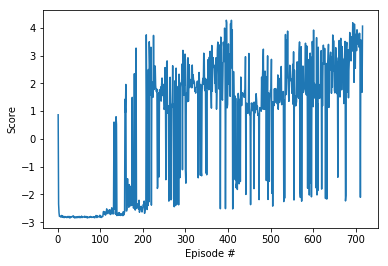

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 401
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)
    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)
  
        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)
       
            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 2.5:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

# Start 716 beacuse the memory for 716 episode is not saved

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 715
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:

    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)
    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):

        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)
     
        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)
    
            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 4.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-715
memory: 270868, total_scores: 715, success: 161
Ep:  716 HV: 12.2 RV: 18.7 Score:  4.024 Average:  2.514 Max: 4.27 F:7 S: 162, Th: 0.76 Steer: -0.03 L: 0.0034, step: 500
Ep:  717 HV: 11.8 RV: 17.1 Score:  3.069 Average:  2.525 Max: 4.27 F:7 S: 163, Th: 0.76 Steer:  0.00 L: 0.0026, step: 500
Ep:  718 HV: 11.7 RV: 16.7 Score:  3.488 Average:  2.544 Max: 4.27 F:7 S: 164, Th: 0.76 Steer:  0.00 L: 0.0031, step: 500
Ep:  719 HV: 13.1 RV: 17.1 Score:  4.008 Average:  2.553 Max: 4.27 F:7 S: 165, Th: 0.79 Steer: -0.02 L: 0.0027, step: 500
Ep:  720 HV: 13.2 RV: 18.6 Score:  3.097 Average:  2.602 Max: 4.27 F:7 S: 166, Th: 0.78 Steer: -0.01 L: 0.0027, step: 500
Ep:  721 HV: 14.6 RV: 18.5 Score:  3.419 Average:  2.609 Max: 4.27 F:7 S: 167, Th: 0.79 Steer: -0.00 L: 0.0031, step: 500
Ep:  722 HV: 14.8 RV: 15.9 Score:  1.791 Average:  2.615 Max: 4.27 F:4 S: 167, Th: 0.80 Ste

KeyboardInterrupt: 

# 767

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 766
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:

    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)
    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):

        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)
        
        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)
        
            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 4.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-766
memory: 294035, total_scores: 766, success: 194
Ep:  767 HV: 12.4 RV: 18.2 Score:  3.906 Average:  2.440 Max: 4.27 F:7 S: 195, Th: 0.77 Steer:  0.00 L: 0.0028, step: 500
Ep:  768 HV: 13.3 RV: 18.5 Score:  2.715 Average:  2.434 Max: 4.27 F:7 S: 196, Th: 0.81 Steer:  0.00 L: 0.0030, step: 500
Ep:  769 HV: 14.4 RV: 18.5 Score:  1.601 Average:  2.421 Max: 4.27 F:4 S: 196, Th: 0.78 Steer:  0.02 L: 0.0025, step: 500
Ep:  770 HV: 12.4 RV: 15.5 Score: -2.111 Average:  2.371 Max: 4.27 F:1 S: 196, Th: 0.76 Steer:  0.01 L: 0.0036, step: 278
Ep:  771 HV: 13.5 RV: 18.1 Score:  3.085 Average:  2.374 Max: 4.27 F:7 S: 197, Th: 0.78 Steer: -0.02 L: 0.0035, step: 500
Ep:  772 HV: 13.9 RV: 17.4 Score:  1.514 Average:  2.376 Max: 4.27 F:4 S: 197, Th: 0.78 Steer: -0.00 L: 0.0031, step: 500
Ep:  773 HV: 13.2 RV: 18.4 Score:  3.045 Average:  2.391 Max: 4.27 F:7 S: 198, Th: 0.79 Ste

SystemExit: 

C:\Users\Lab\Anaconda3\envs\airsim\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 776 

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 775
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)
    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)

        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 4.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-775
memory: 298313, total_scores: 775, success: 199
Ep:  776 HV: 12.1 RV: 18.3 Score:  3.454 Average:  2.442 Max: 4.27 F:7 S: 200, Th: 0.77 Steer: -0.01 L: 0.0038, step: 500
Ep:  777 HV: 12.5 RV: 18.8 Score:  1.306 Average:  2.476 Max: 4.27 F:4 S: 200, Th: 0.79 Steer: -0.01 L: 0.0028, step: 500
Ep:  778 HV: 14.1 RV: 18.8 Score:  2.611 Average:  2.469 Max: 4.27 F:7 S: 201, Th: 0.77 Steer:  0.00 L: 0.0027, step: 500
Ep:  779 HV: 12.9 RV: 17.1 Score:  3.757 Average:  2.472 Max: 4.27 F:7 S: 202, Th: 0.78 Steer:  0.00 L: 0.0029, step: 500
Ep:  780 HV: 13.9 RV: 18.8 Score:  1.766 Average:  2.473 Max: 4.27 F:4 S: 202, Th: 0.79 Steer: -0.03 L: 0.0031, step: 500
Ep:  781 HV: 11.5 RV: 15.0 Score: -2.443 Average:  2.432 Max: 4.27 F:1 S: 202, Th: 0.76 Steer: -0.02 L: 0.0026, step: 191
Ep:  782 HV: 12.1 RV: 16.8 Score:  2.355 Average:  2.423 Max: 4.27 F:4 S: 202, Th: 0.75 Ste

Ep:  842 HV: 12.1 RV: 15.0 Score: -2.498 Average:  1.580 Max: 4.27 F:1 S: 237, Th: 0.78 Steer:  0.02 L: 0.0040, step: 181
Ep:  843 HV: 16.5 RV: 18.7 Score:  3.057 Average:  1.634 Max: 4.27 F:7 S: 238, Th: 0.80 Steer: -0.01 L: 0.0032, step: 500
Ep:  844 HV: 14.6 RV: 17.0 Score:  1.636 Average:  1.630 Max: 4.27 F:4 S: 238, Th: 0.81 Steer: -0.00 L: 0.0029, step: 500
Ep:  845 HV: 12.3 RV: 17.0 Score:  3.399 Average:  1.687 Max: 4.27 F:7 S: 239, Th: 0.77 Steer: -0.01 L: 0.0028, step: 500
Ep:  846 HV: 14.1 RV: 17.0 Score:  2.884 Average:  1.682 Max: 4.27 F:7 S: 240, Th: 0.76 Steer: -0.00 L: 0.0028, step: 500
Ep:  847 HV: 15.5 RV: 16.5 Score: -1.113 Average:  1.637 Max: 4.27 F:1 S: 240, Th: 0.81 Steer: -0.02 L: 0.0035, step: 471
Collision error happen!!


SystemExit: 

C:\Users\Lab\Anaconda3\envs\airsim\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 848

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 847
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)
    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)

        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 4.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-847
memory: 329925, total_scores: 847, success: 240
Ep:  848 HV: 14.8 RV: 17.1 Score:  2.687 Average:  1.642 Max: 4.27 F:7 S: 241, Th: 0.81 Steer: -0.01 L: 0.0028, step: 500
Ep:  849 HV: 12.6 RV: 18.2 Score:  2.507 Average:  1.650 Max: 4.27 F:4 S: 241, Th: 0.77 Steer: -0.00 L: 0.0025, step: 500
Ep:  850 HV: 15.3 RV: 18.6 Score:  2.512 Average:  1.641 Max: 4.27 F:4 S: 241, Th: 0.72 Steer:  0.00 L: 0.0032, step: 500
Ep:  851 HV: 13.2 RV: 16.1 Score:  3.432 Average:  1.694 Max: 4.27 F:7 S: 242, Th: 0.71 Steer: -0.02 L: 0.0026, step: 500
Ep:  852 HV: 13.7 RV: 18.9 Score:  3.337 Average:  1.748 Max: 4.27 F:7 S: 243, Th: 0.75 Steer: -0.02 L: 0.0027, step: 500
Ep:  853 HV: 13.2 RV: 18.6 Score:  4.200 Average:  1.762 Max: 4.27 F:7 S: 244, Th: 0.75 Steer: -0.01 L: 0.0028, step: 500
Ep:  854 HV: 13.9 RV: 15.8 Score: -1.613 Average:  1.712 Max: 4.27 F:1 S: 244, Th: 0.79 Ste

SystemExit: 

C:\Users\Lab\Anaconda3\envs\airsim\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 857

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 856
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)
    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)

        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 4.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-856
memory: 334300, total_scores: 856, success: 245
Ep:  857 HV: 13.4 RV: 16.3 Score:  1.889 Average:  1.806 Max: 4.27 F:4 S: 245, Th: 0.72 Steer:  0.00 L: 0.0028, step: 500
Ep:  858 HV: 14.9 RV: 17.1 Score: -1.820 Average:  1.807 Max: 4.27 F:1 S: 245, Th: 0.83 Steer: -0.01 L: 0.0020, step: 309
Ep:  859 HV: 12.2 RV: 18.5 Score:  3.987 Average:  1.865 Max: 4.27 F:7 S: 246, Th: 0.72 Steer:  0.01 L: 0.0036, step: 500
Ep:  860 HV: 12.2 RV: 18.9 Score:  4.396 Average:  1.893 Max: 4.40 F:7 S: 247, Th: 0.76 Steer: -0.01 L: 0.0034, step: 500
Ep:  861 HV: 12.3 RV: 15.3 Score: -2.428 Average:  1.851 Max: 4.40 F:1 S: 247, Th: 0.57 Steer: -0.04 L: 0.0034, step: 204
Ep:  862 HV:  9.8 RV: 16.8 Score:  3.730 Average:  1.853 Max: 4.40 F:7 S: 248, Th: 0.67 Steer:  0.01 L: 0.0028, step: 500
Ep:  863 HV: 12.0 RV: 15.5 Score: -2.342 Average:  1.798 Max: 4.40 F:1 S: 248, Th: 0.61 Ste

Ep:  923 HV: 12.0 RV: 17.1 Score:  3.791 Average:  2.231 Max: 4.40 F:7 S: 290, Th: 0.71 Steer:  0.01 L: 0.0038, step: 500
Ep:  924 HV: 12.4 RV: 18.5 Score:  3.843 Average:  2.243 Max: 4.40 F:7 S: 291, Th: 0.72 Steer: -0.01 L: 0.0030, step: 500
Ep:  925 HV: 10.8 RV: 17.5 Score:  1.990 Average:  2.222 Max: 4.40 F:4 S: 291, Th: 0.72 Steer: -0.02 L: 0.0030, step: 500
Ep:  926 HV: 11.5 RV: 15.7 Score:  2.684 Average:  2.213 Max: 4.40 F:4 S: 291, Th: 0.73 Steer:  0.01 L: 0.0042, step: 500
Ep:  927 HV: 10.5 RV: 17.2 Score:  3.684 Average:  2.274 Max: 4.40 F:7 S: 292, Th: 0.72 Steer: -0.01 L: 0.0030, step: 500
Ep:  928 HV: 11.3 RV: 17.7 Score:  3.521 Average:  2.286 Max: 4.40 F:7 S: 293, Th: 0.75 Steer: -0.03 L: 0.0033, step: 500
Ep:  929 HV: 11.0 RV: 17.2 Score:  4.099 Average:  2.350 Max: 4.40 F:7 S: 294, Th: 0.74 Steer: -0.01 L: 0.0030, step: 500
Ep:  930 HV: 11.8 RV: 16.5 Score:  2.742 Average:  2.401 Max: 4.40 F:4 S: 294, Th: 0.72 Steer: -0.02 L: 0.0027, step: 500
Ep:  931 HV: 12.9 RV: 17

Ep:  991 HV: 11.0 RV: 17.7 Score:  4.012 Average:  3.375 Max: 4.40 F:7 S: 351, Th: 0.74 Steer:  0.03 L: 0.0026, step: 500
Ep:  992 HV: 11.4 RV: 18.7 Score:  4.398 Average:  3.382 Max: 4.40 F:7 S: 352, Th: 0.74 Steer: -0.00 L: 0.0028, step: 500
Ep:  993 HV: 11.1 RV: 16.0 Score:  3.017 Average:  3.383 Max: 4.40 F:7 S: 353, Th: 0.71 Steer: -0.01 L: 0.0028, step: 500
Ep:  994 HV: 11.7 RV: 17.6 Score:  3.691 Average:  3.389 Max: 4.40 F:7 S: 354, Th: 0.77 Steer: -0.02 L: 0.0029, step: 500
Ep:  995 HV: 11.3 RV: 18.0 Score:  2.512 Average:  3.401 Max: 4.40 F:4 S: 354, Th: 0.72 Steer: -0.01 L: 0.0030, step: 500
Ep:  996 HV: 12.2 RV: 16.9 Score:  2.444 Average:  3.390 Max: 4.40 F:4 S: 354, Th: 0.73 Steer:  0.01 L: 0.0027, step: 500
Ep:  997 HV: 11.7 RV: 18.2 Score:  3.706 Average:  3.388 Max: 4.40 F:7 S: 355, Th: 0.75 Steer: -0.00 L: 0.0028, step: 500
Ep:  998 HV: 11.7 RV: 16.4 Score:  3.263 Average:  3.388 Max: 4.40 F:7 S: 356, Th: 0.72 Steer: -0.00 L: 0.0029, step: 500
Ep:  999 HV: 12.0 RV: 15

Ep: 1059 HV: 13.0 RV: 15.7 Score:  3.067 Average:  3.348 Max: 4.53 F:7 S: 405, Th: 0.75 Steer:  0.01 L: 0.0030, step: 500
Ep: 1060 HV: 11.4 RV: 16.3 Score:  3.923 Average:  3.347 Max: 4.53 F:7 S: 406, Th: 0.69 Steer: -0.01 L: 0.0028, step: 500
Ep: 1061 HV: 12.6 RV: 18.5 Score:  3.824 Average:  3.346 Max: 4.53 F:7 S: 407, Th: 0.79 Steer:  0.01 L: 0.0024, step: 500
Ep: 1062 HV: 14.1 RV: 15.5 Score: -1.714 Average:  3.289 Max: 4.53 F:1 S: 407, Th: 0.76 Steer: -0.01 L: 0.0030, step: 386
Ep: 1063 HV: 12.2 RV: 18.4 Score:  3.661 Average:  3.290 Max: 4.53 F:7 S: 408, Th: 0.75 Steer: -0.01 L: 0.0031, step: 500
Ep: 1064 HV: 14.8 RV: 18.7 Score:  3.611 Average:  3.290 Max: 4.53 F:7 S: 409, Th: 0.81 Steer: -0.00 L: 0.0030, step: 500
Ep: 1065 HV: 14.5 RV: 16.8 Score:  3.396 Average:  3.286 Max: 4.53 F:7 S: 410, Th: 0.79 Steer: -0.01 L: 0.0032, step: 500
Ep: 1066 HV: 15.2 RV: 16.6 Score: -2.043 Average:  3.227 Max: 4.53 F:3 S: 410, Th: 0.84 Steer:  0.02 L: 0.0030, step: 275
Ep: 1067 HV: 14.0 RV: 16

SystemExit: 

C:\Users\Lab\Anaconda3\envs\airsim\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 1104

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 1103
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)
    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)

        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 4.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-1103
memory: 451422, total_scores: 1103, success: 436
Ep: 1104 HV: 13.3 RV: 15.4 Score: -2.289 Average:  2.756 Max: 4.85 F:1 S: 436, Th: 0.66 Steer: -0.02 L: 0.0034, step: 242
Ep: 1105 HV: 12.2 RV: 18.0 Score:  4.033 Average:  2.757 Max: 4.85 F:7 S: 437, Th: 0.75 Steer:  0.00 L: 0.0035, step: 500
Ep: 1106 HV: 10.8 RV: 18.1 Score:  3.100 Average:  2.748 Max: 4.85 F:7 S: 438, Th: 0.70 Steer: -0.01 L: 0.0035, step: 500
Ep: 1107 HV: 13.1 RV: 15.4 Score: -2.366 Average:  2.683 Max: 4.85 F:1 S: 438, Th: 0.58 Steer: -0.00 L: 0.0031, step: 215
Collision error happen!!


SystemExit: 

C:\Users\Lab\Anaconda3\envs\airsim\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 1108

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 1107
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)
    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)
        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 4.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-1107
memory: 452879, total_scores: 1107, success: 438
Ep: 1108 HV: 12.6 RV: 14.8 Score: -2.483 Average:  2.630 Max: 4.85 F:2 S: 438, Th: 0.55 Steer: -0.00 L: 0.0022, step: 181
Ep: 1109 HV: 12.6 RV: 15.3 Score: -2.444 Average:  2.566 Max: 4.85 F:1 S: 438, Th: 0.62 Steer: -0.02 L: 0.0031, step: 200
Ep: 1110 HV: 12.6 RV: 15.3 Score: -2.378 Average:  2.503 Max: 4.85 F:1 S: 438, Th: 0.68 Steer: -0.03 L: 0.0021, step: 223
Ep: 1111 HV: 13.1 RV: 15.2 Score: -2.422 Average:  2.448 Max: 4.85 F:2 S: 438, Th: 0.69 Steer: -0.07 L: 0.0048, step: 195
Ep: 1112 HV: 12.9 RV: 15.0 Score: -2.416 Average:  2.403 Max: 4.85 F:2 S: 438, Th: 0.67 Steer: -0.01 L: 0.0029, step: 193
Ep: 1113 HV: 13.3 RV: 15.9 Score: -2.344 Average:  2.358 Max: 4.85 F:1 S: 438, Th: 0.72 Steer: -0.01 L: 0.0030, step: 230
Ep: 1114 HV: 12.2 RV: 15.1 Score: -2.427 Average:  2.298 Max: 4.85 F:1 S: 438, Th: 0.68 S

SystemExit: 

C:\Users\Lab\Anaconda3\envs\airsim\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 1156

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 1155
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)
    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)

        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 4.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-1155
memory: 471880, total_scores: 1155, success: 466
Ep: 1156 HV: 11.1 RV: 16.4 Score:  3.999 Average:  1.749 Max: 4.85 F:7 S: 467, Th: 0.71 Steer:  0.01 L: 0.0030, step: 500
Ep: 1157 HV: 11.0 RV: 16.3 Score:  3.768 Average:  1.748 Max: 4.85 F:7 S: 468, Th: 0.72 Steer: -0.01 L: 0.0029, step: 500
Ep: 1158 HV: 13.4 RV: 16.2 Score: -2.165 Average:  1.684 Max: 4.85 F:1 S: 468, Th: 0.76 Steer: -0.03 L: 0.0026, step: 266
Ep: 1159 HV: 11.7 RV: 15.8 Score:  3.692 Average:  1.690 Max: 4.85 F:7 S: 469, Th: 0.70 Steer:  0.03 L: 0.0029, step: 500
Ep: 1160 HV: 11.7 RV: 18.5 Score:  3.748 Average:  1.688 Max: 4.85 F:7 S: 470, Th: 0.72 Steer: -0.01 L: 0.0033, step: 500
Ep: 1161 HV: 13.0 RV: 16.4 Score:  4.034 Average:  1.691 Max: 4.85 F:7 S: 471, Th: 0.78 Steer:  0.01 L: 0.0030, step: 500
Ep: 1162 HV: 13.1 RV: 15.6 Score:  3.790 Average:  1.746 Max: 4.85 F:7 S: 472, Th: 0.80 S

Ep: 1222 HV: 12.1 RV: 17.0 Score:  4.152 Average:  2.775 Max: 4.85 F:7 S: 521, Th: 0.74 Steer: -0.01 L: 0.0033, step: 500
Ep: 1223 HV: 12.5 RV: 18.7 Score:  4.272 Average:  2.783 Max: 4.85 F:7 S: 522, Th: 0.76 Steer: -0.00 L: 0.0031, step: 500
Ep: 1224 HV: 13.1 RV: 15.8 Score:  3.199 Average:  2.777 Max: 4.85 F:7 S: 523, Th: 0.71 Steer:  0.01 L: 0.0038, step: 500
Ep: 1225 HV: 11.2 RV: 17.6 Score:  3.272 Average:  2.833 Max: 4.85 F:7 S: 524, Th: 0.71 Steer: -0.01 L: 0.0030, step: 500
Ep: 1226 HV: 11.9 RV: 18.4 Score:  4.229 Average:  2.834 Max: 4.85 F:7 S: 525, Th: 0.72 Steer: -0.02 L: 0.0029, step: 500
Ep: 1227 HV: 11.7 RV: 17.6 Score:  4.065 Average:  2.893 Max: 4.85 F:7 S: 526, Th: 0.72 Steer: -0.02 L: 0.0037, step: 500
Ep: 1228 HV: 12.1 RV: 18.6 Score:  4.339 Average:  2.957 Max: 4.85 F:7 S: 527, Th: 0.75 Steer:  0.00 L: 0.0030, step: 500
Ep: 1229 HV: 12.3 RV: 15.1 Score: -2.423 Average:  2.893 Max: 4.85 F:3 S: 527, Th: 0.77 Steer:  0.05 L: 0.0034, step: 187
Ep: 1230 HV: 12.3 RV: 16

SystemExit: 

C:\Users\Lab\Anaconda3\envs\airsim\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 1242

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 1241
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)

    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)

        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 4.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-1241
memory: 512300, total_scores: 1241, success: 538
Ep: 1242 HV: 13.4 RV: 17.1 Score:  2.862 Average:  2.963 Max: 4.85 F:4 S: 538, Th: 0.77 Steer:  0.02 L: 0.0037, step: 500
Ep: 1243 HV: 13.9 RV: 18.2 Score:  3.936 Average:  2.961 Max: 4.85 F:7 S: 539, Th: 0.77 Steer:  0.00 L: 0.0035, step: 500
Ep: 1244 HV: 11.7 RV: 19.0 Score:  4.355 Average:  3.022 Max: 4.85 F:7 S: 540, Th: 0.74 Steer:  0.01 L: 0.0034, step: 500
Ep: 1245 HV: 12.9 RV: 18.5 Score:  3.966 Average:  3.019 Max: 4.85 F:7 S: 541, Th: 0.78 Steer:  0.01 L: 0.0031, step: 500
Ep: 1246 HV: 11.1 RV: 16.3 Score:  3.654 Average:  3.016 Max: 4.85 F:7 S: 542, Th: 0.71 Steer: -0.01 L: 0.0034, step: 500
Ep: 1247 HV: 12.3 RV: 18.5 Score:  4.396 Average:  3.081 Max: 4.85 F:7 S: 543, Th: 0.75 Steer: -0.00 L: 0.0036, step: 500
Ep: 1248 HV: 11.4 RV: 18.5 Score:  3.874 Average:  3.078 Max: 4.85 F:7 S: 544, Th: 0.70 S

Ep: 1308 HV: 12.4 RV: 14.7 Score: -2.473 Average:  3.189 Max: 4.85 F:3 S: 595, Th: 0.69 Steer:  0.02 L: 0.0045, step: 172
Ep: 1309 HV: 12.5 RV: 15.0 Score: -2.435 Average:  3.184 Max: 4.85 F:3 S: 595, Th: 0.66 Steer:  0.02 L: 0.0034, step: 182
Ep: 1310 HV: 10.8 RV: 16.8 Score:  3.504 Average:  3.177 Max: 4.85 F:7 S: 596, Th: 0.72 Steer: -0.00 L: 0.0027, step: 500
Ep: 1311 HV: 11.2 RV: 18.1 Score:  3.917 Average:  3.178 Max: 4.85 F:7 S: 597, Th: 0.71 Steer:  0.01 L: 0.0029, step: 500
Ep: 1312 HV: 11.0 RV: 18.0 Score:  3.893 Average:  3.176 Max: 4.85 F:7 S: 598, Th: 0.73 Steer: -0.01 L: 0.0032, step: 500
Ep: 1313 HV: 13.6 RV: 18.2 Score:  4.364 Average:  3.186 Max: 4.85 F:7 S: 599, Th: 0.77 Steer: -0.01 L: 0.0040, step: 500
Ep: 1314 HV: 11.7 RV: 18.5 Score:  4.239 Average:  3.192 Max: 4.85 F:7 S: 600, Th: 0.75 Steer: -0.00 L: 0.0030, step: 500
Ep: 1315 HV: 11.0 RV: 18.6 Score:  4.103 Average:  3.197 Max: 4.85 F:7 S: 601, Th: 0.70 Steer: -0.02 L: 0.0031, step: 500
Ep: 1316 HV: 11.2 RV: 18

SystemExit: 

C:\Users\Lab\Anaconda3\envs\airsim\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 1327

In [ ]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 1326
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)

    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)

        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 4.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-1326
memory: 551310, total_scores: 1326, success: 609
Ep: 1327 HV: 12.4 RV: 15.7 Score: -2.253 Average:  3.062 Max: 4.85 F:1 S: 609, Th: 0.75 Steer: -0.06 L: 0.0028, step: 227
Ep: 1328 HV: 14.3 RV: 17.7 Score:  3.592 Average:  3.055 Max: 4.85 F:7 S: 610, Th: 0.77 Steer:  0.00 L: 0.0028, step: 500
Ep: 1329 HV: 12.9 RV: 18.9 Score:  4.250 Average:  3.122 Max: 4.85 F:7 S: 611, Th: 0.77 Steer:  0.01 L: 0.0024, step: 500
Ep: 1330 HV: 11.4 RV: 19.0 Score:  4.427 Average:  3.131 Max: 4.85 F:7 S: 612, Th: 0.71 Steer: -0.01 L: 0.0026, step: 500
Ep: 1331 HV: 13.3 RV: 17.7 Score:  3.999 Average:  3.131 Max: 4.85 F:7 S: 613, Th: 0.76 Steer: -0.02 L: 0.0035, step: 500
Ep: 1332 HV: 12.2 RV: 17.7 Score:  4.121 Average:  3.134 Max: 4.85 F:7 S: 614, Th: 0.78 Steer:  0.01 L: 0.0028, step: 500
Ep: 1333 HV: 14.0 RV: 14.9 Score: -2.388 Average:  3.075 Max: 4.85 F:3 S: 614, Th: 0.82 S

# 1354

In [ ]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 1353
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)

    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)

        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 4.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-1353
memory: 563934, total_scores: 1353, success: 633
Ep: 1354 HV: 11.7 RV: 18.4 Score:  4.475 Average:  3.129 Max: 4.85 F:7 S: 634, Th: 0.74 Steer:  0.00 L: 0.0044, step: 500
Ep: 1355 HV: 11.2 RV: 17.9 Score:  4.497 Average:  3.133 Max: 4.85 F:7 S: 635, Th: 0.71 Steer:  0.00 L: 0.0032, step: 500
Ep: 1356 HV: 11.4 RV: 18.3 Score:  3.778 Average:  3.130 Max: 4.85 F:7 S: 636, Th: 0.70 Steer: -0.01 L: 0.0032, step: 500
Ep: 1357 HV: 10.2 RV: 16.9 Score:  4.446 Average:  3.133 Max: 4.85 F:7 S: 637, Th: 0.69 Steer:  0.01 L: 0.0035, step: 500
Ep: 1358 HV: 11.5 RV: 18.5 Score:  4.228 Average:  3.136 Max: 4.85 F:7 S: 638, Th: 0.72 Steer:  0.01 L: 0.0032, step: 500
Ep: 1359 HV: 12.2 RV: 15.6 Score: -2.328 Average:  3.077 Max: 4.85 F:1 S: 638, Th: 0.65 Steer: -0.05 L: 0.0033, step: 217
Ep: 1360 HV: 11.1 RV: 15.1 Score: -2.430 Average:  3.077 Max: 4.85 F:1 S: 638, Th: 0.66 S

Ep: 1420 HV: 10.0 RV: 18.6 Score:  3.986 Average:  3.365 Max: 4.85 F:7 S: 693, Th: 0.69 Steer:  0.00 L: 0.0036, step: 500
Ep: 1421 HV: 11.0 RV: 14.8 Score: -2.518 Average:  3.299 Max: 4.85 F:1 S: 693, Th: 0.62 Steer: -0.06 L: 0.0026, step: 170
Ep: 1422 HV: 12.9 RV: 15.6 Score: -2.291 Average:  3.240 Max: 4.85 F:1 S: 693, Th: 0.70 Steer: -0.09 L: 0.0037, step: 214
Ep: 1423 HV: 12.7 RV: 15.8 Score: -2.213 Average:  3.177 Max: 4.85 F:1 S: 693, Th: 0.70 Steer: -0.01 L: 0.0035, step: 230
Ep: 1424 HV: 11.2 RV: 17.3 Score:  3.953 Average:  3.200 Max: 4.85 F:7 S: 694, Th: 0.72 Steer:  0.01 L: 0.0032, step: 500
Ep: 1425 HV: 12.1 RV: 16.9 Score:  4.051 Average:  3.264 Max: 4.85 F:7 S: 695, Th: 0.74 Steer:  0.00 L: 0.0030, step: 500
Ep: 1426 HV: 11.6 RV: 18.6 Score:  4.315 Average:  3.270 Max: 4.85 F:7 S: 696, Th: 0.71 Steer: -0.01 L: 0.0038, step: 500
Ep: 1427 HV: 12.1 RV: 16.6 Score:  4.115 Average:  3.334 Max: 4.85 F:7 S: 697, Th: 0.76 Steer: -0.01 L: 0.0029, step: 500
Ep: 1428 HV: 13.6 RV: 18

# 1458

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 1457
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:    
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)

    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)

        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 4.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-1457
memory: 612180, total_scores: 1457, success: 722
Ep: 1458 HV: 10.4 RV: 15.6 Score:  3.799 Average:  3.132 Max: 4.85 F:7 S: 723, Th: 0.70 Steer: -0.01 L: 0.0037, step: 500
Ep: 1459 HV: 11.4 RV: 18.7 Score:  4.318 Average:  3.199 Max: 4.85 F:7 S: 724, Th: 0.74 Steer:  0.00 L: 0.0038, step: 500
Ep: 1460 HV: 12.6 RV: 15.5 Score: -2.270 Average:  3.201 Max: 4.85 F:1 S: 724, Th: 0.66 Steer: -0.04 L: 0.0031, step: 218
Ep: 1461 HV: 11.4 RV: 17.2 Score:  4.248 Average:  3.202 Max: 4.85 F:7 S: 725, Th: 0.72 Steer: -0.00 L: 0.0036, step: 500
Ep: 1462 HV: 12.8 RV: 17.8 Score:  3.646 Average:  3.196 Max: 4.85 F:7 S: 726, Th: 0.75 Steer: -0.00 L: 0.0039, step: 500
Ep: 1463 HV: 12.0 RV: 19.0 Score:  4.104 Average:  3.196 Max: 4.85 F:7 S: 727, Th: 0.74 Steer: -0.02 L: 0.0031, step: 500
Ep: 1464 HV: 11.9 RV: 18.0 Score:  4.081 Average:  3.195 Max: 4.85 F:7 S: 728, Th: 0.72 S

SystemExit: 

C:\Users\Lab\Anaconda3\envs\airsim\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 1495

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 1494
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)

    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
   
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)

        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 4.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-1494
memory: 628206, total_scores: 1494, success: 748
Ep: 1495 HV: 12.2 RV: 18.5 Score:  2.567 Average:  2.685 Max: 4.85 F:4 S: 748, Th: 0.73 Steer:  0.01 L: 0.0032, step: 500
Ep: 1496 HV: 13.8 RV: 15.6 Score: -1.853 Average:  2.620 Max: 4.85 F:1 S: 748, Th: 0.76 Steer: -0.02 L: 0.0034, step: 331
Ep: 1497 HV: 13.7 RV: 16.4 Score: -2.014 Average:  2.559 Max: 4.85 F:1 S: 748, Th: 0.69 Steer: -0.04 L: 0.0026, step: 281
Ep: 1498 HV: 12.0 RV: 15.8 Score:  4.045 Average:  2.554 Max: 4.85 F:7 S: 749, Th: 0.74 Steer: -0.01 L: 0.0033, step: 500
Ep: 1499 HV: 11.5 RV: 19.0 Score:  3.146 Average:  2.546 Max: 4.85 F:4 S: 749, Th: 0.76 Steer: -0.03 L: 0.0029, step: 500
Ep: 1500 HV: 15.3 RV: 17.8 Score:  3.114 Average:  2.535 Max: 4.85 F:7 S: 750, Th: 0.78 Steer: -0.00 L: 0.0035, step: 500
Ep: 1501 HV: 13.0 RV: 18.7 Score:  2.668 Average:  2.583 Max: 4.85 F:4 S: 750, Th: 0.76 S

SystemExit: 

C:\Users\Lab\Anaconda3\envs\airsim\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 1530

In [ ]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 1529
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)

    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)

        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 4.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-1529
memory: 643516, total_scores: 1529, success: 768
Ep: 1530 HV: 13.8 RV: 15.6 Score: -2.304 Average:  2.486 Max: 4.85 F:1 S: 768, Th: 0.65 Steer: -0.02 L: 0.0031, step: 216
Ep: 1531 HV: 11.4 RV: 14.7 Score: -2.497 Average:  2.482 Max: 4.85 F:1 S: 768, Th: 0.57 Steer: -0.08 L: 0.0037, step: 169
Ep: 1532 HV: 12.6 RV: 15.0 Score: -2.393 Average:  2.420 Max: 4.85 F:1 S: 768, Th: 0.64 Steer: -0.06 L: 0.0041, step: 192
Ep: 1533 HV: 12.7 RV: 15.1 Score: -2.376 Average:  2.359 Max: 4.85 F:1 S: 768, Th: 0.75 Steer: -0.02 L: 0.0040, step: 199
Ep: 1534 HV: 12.7 RV: 14.7 Score: -2.483 Average:  2.355 Max: 4.85 F:1 S: 768, Th: 0.52 Steer: -0.04 L: 0.0033, step: 178
Ep: 1535 HV: 12.3 RV: 16.4 Score:  2.951 Average:  2.342 Max: 4.85 F:7 S: 769, Th: 0.74 Steer: -0.00 L: 0.0029, step: 500
Ep: 1536 HV: 13.0 RV: 16.3 Score:  1.590 Average:  2.313 Max: 4.85 F:4 S: 769, Th: 0.72 S

# 1539

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 1538
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)

    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)

        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 4.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-1538
memory: 646470, total_scores: 1538, success: 771
Ep: 1539 HV: 13.7 RV: 16.5 Score: -1.969 Average:  2.317 Max: 4.85 F:1 S: 771, Th: 0.70 Steer: -0.03 L: 0.0032, step: 290
Ep: 1540 HV: 11.6 RV: 17.1 Score:  4.056 Average:  2.313 Max: 4.85 F:7 S: 772, Th: 0.71 Steer: -0.02 L: 0.0043, step: 500
Ep: 1541 HV: 12.3 RV: 18.4 Score:  4.421 Average:  2.314 Max: 4.85 F:7 S: 773, Th: 0.76 Steer:  0.00 L: 0.0029, step: 500
Ep: 1542 HV: 12.4 RV: 17.9 Score:  4.178 Average:  2.321 Max: 4.85 F:7 S: 774, Th: 0.75 Steer: -0.00 L: 0.0039, step: 500
Ep: 1543 HV: 12.6 RV: 15.9 Score: -2.165 Average:  2.260 Max: 4.85 F:1 S: 774, Th: 0.71 Steer: -0.03 L: 0.0033, step: 253
Ep: 1544 HV: 10.6 RV: 17.5 Score:  4.134 Average:  2.257 Max: 4.85 F:7 S: 775, Th: 0.66 Steer: -0.01 L: 0.0032, step: 500
Ep: 1545 HV: 12.0 RV: 15.6 Score: -2.259 Average:  2.195 Max: 4.85 F:1 S: 775, Th: 0.75 S

SystemExit: 

C:\Users\Lab\Anaconda3\envs\airsim\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 1601

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 1600
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)

    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)

        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 4.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-1600
memory: 674703, total_scores: 1600, success: 820
Ep: 1601 HV: 12.5 RV: 14.7 Score: -2.509 Average:  2.413 Max: 4.85 F:2 S: 820, Th: 0.63 Steer: -0.03 L: 0.0033, step: 180
Ep: 1602 HV: 12.2 RV: 15.2 Score: -2.411 Average:  2.366 Max: 4.85 F:1 S: 820, Th: 0.76 Steer: -0.01 L: 0.0045, step: 225
Ep: 1603 HV: 11.3 RV: 18.6 Score:  4.424 Average:  2.368 Max: 4.85 F:7 S: 821, Th: 0.74 Steer: -0.02 L: 0.0037, step: 500
Ep: 1604 HV: 12.4 RV: 17.7 Score:  4.436 Average:  2.372 Max: 4.85 F:7 S: 822, Th: 0.73 Steer: -0.03 L: 0.0035, step: 500
Ep: 1605 HV: 10.6 RV: 17.3 Score:  4.236 Average:  2.372 Max: 4.85 F:7 S: 823, Th: 0.73 Steer: -0.00 L: 0.0030, step: 500
Ep: 1606 HV:  9.2 RV: 18.2 Score:  3.993 Average:  2.377 Max: 4.85 F:7 S: 824, Th: 0.69 Steer: -0.00 L: 0.0034, step: 500
Ep: 1607 HV: 15.2 RV: 16.6 Score: -1.911 Average:  2.381 Max: 4.85 F:2 S: 824, Th: 0.81 S

TimeoutError: Request timed out

1609

In [ ]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 1608
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)

    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)

        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 4.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-1608
memory: 677897, total_scores: 1608, success: 825
Ep: 1609 HV: 12.7 RV: 15.5 Score: -2.446 Average:  2.311 Max: 4.85 F:1 S: 825, Th: 0.69 Steer: -0.03 L: 0.0024, step: 196
Ep: 1610 HV: 12.1 RV: 16.4 Score:  3.422 Average:  2.368 Max: 4.85 F:7 S: 826, Th: 0.73 Steer:  0.01 L: 0.0030, step: 500
Ep: 1611 HV: 13.1 RV: 18.6 Score:  3.601 Average:  2.426 Max: 4.85 F:7 S: 827, Th: 0.78 Steer: -0.02 L: 0.0036, step: 500
Ep: 1612 HV: 15.6 RV: 16.0 Score:  3.275 Average:  2.412 Max: 4.85 F:7 S: 828, Th: 0.73 Steer: -0.00 L: 0.0031, step: 500
Ep: 1613 HV: 13.3 RV: 16.2 Score: -2.173 Average:  2.348 Max: 4.85 F:1 S: 828, Th: 0.65 Steer: -0.04 L: 0.0035, step: 248
Ep: 1614 HV:  9.8 RV: 16.9 Score:  3.909 Average:  2.347 Max: 4.85 F:7 S: 829, Th: 0.64 Steer:  0.00 L: 0.0034, step: 500
Ep: 1615 HV:  9.4 RV: 16.8 Score:  3.958 Average:  2.343 Max: 4.85 F:7 S: 830, Th: 0.62 S

1627

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 1626
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)

    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)

        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 4.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-1626
memory: 686341, total_scores: 1626, success: 840
Ep: 1627 HV: 13.5 RV: 18.6 Score:  3.031 Average:  2.531 Max: 4.85 F:7 S: 841, Th: 0.73 Steer: -0.01 L: 0.0032, step: 500
Ep: 1628 HV: 10.4 RV: 16.8 Score:  4.108 Average:  2.529 Max: 4.85 F:7 S: 842, Th: 0.69 Steer: -0.00 L: 0.0031, step: 500
Ep: 1629 HV: 10.3 RV: 19.0 Score:  3.722 Average:  2.588 Max: 4.85 F:7 S: 843, Th: 0.68 Steer: -0.02 L: 0.0041, step: 500
Ep: 1630 HV: 10.5 RV: 18.8 Score:  4.301 Average:  2.654 Max: 4.85 F:7 S: 844, Th: 0.67 Steer: -0.01 L: 0.0040, step: 500
Ep: 1631 HV:  9.9 RV: 18.0 Score:  4.098 Average:  2.720 Max: 4.85 F:7 S: 845, Th: 0.62 Steer: -0.00 L: 0.0033, step: 500
Ep: 1632 HV: 10.0 RV: 15.8 Score:  4.045 Average:  2.785 Max: 4.85 F:7 S: 846, Th: 0.61 Steer: -0.00 L: 0.0040, step: 500
Ep: 1633 HV: 14.0 RV: 16.5 Score: -2.000 Average:  2.789 Max: 4.85 F:1 S: 846, Th: 0.74 S

SystemExit: 

C:\Users\Lab\Anaconda3\envs\airsim\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 1640

In [ ]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 1639
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)

    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)

        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 4.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-1639
memory: 692269, total_scores: 1639, success: 850
Ep: 1640 HV: 12.8 RV: 15.3 Score: -2.273 Average:  2.766 Max: 4.85 F:1 S: 850, Th: 0.59 Steer: -0.04 L: 0.0038, step: 219
Ep: 1641 HV: 11.4 RV: 18.9 Score:  4.415 Average:  2.766 Max: 4.85 F:7 S: 851, Th: 0.73 Steer: -0.00 L: 0.0033, step: 500
Ep: 1642 HV: 12.9 RV: 15.3 Score: -1.969 Average:  2.705 Max: 4.85 F:1 S: 851, Th: 0.63 Steer: -0.03 L: 0.0038, step: 326
Ep: 1643 HV: 10.7 RV: 17.7 Score:  4.226 Average:  2.768 Max: 4.85 F:7 S: 852, Th: 0.68 Steer:  0.02 L: 0.0045, step: 500
Ep: 1644 HV: 10.8 RV: 17.4 Score:  4.066 Average:  2.768 Max: 4.85 F:7 S: 853, Th: 0.69 Steer:  0.00 L: 0.0029, step: 500
Ep: 1645 HV: 11.4 RV: 16.9 Score:  3.565 Average:  2.826 Max: 4.85 F:7 S: 854, Th: 0.71 Steer:  0.01 L: 0.0029, step: 500
Ep: 1646 HV: 12.9 RV: 16.0 Score: -2.183 Average:  2.769 Max: 4.85 F:1 S: 854, Th: 0.62 S

# 1546

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 1645
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)

    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)

        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 4.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-1645
memory: 694814, total_scores: 1645, success: 854
Ep: 1646 HV: 11.4 RV: 17.3 Score:  4.132 Average:  2.832 Max: 4.85 F:7 S: 855, Th: 0.69 Steer:  0.01 L: 0.0035, step: 500
Ep: 1647 HV:  9.9 RV: 15.7 Score:  4.012 Average:  2.828 Max: 4.85 F:7 S: 856, Th: 0.64 Steer: -0.00 L: 0.0029, step: 500
Ep: 1648 HV: 10.3 RV: 18.8 Score:  4.045 Average:  2.837 Max: 4.85 F:7 S: 857, Th: 0.68 Steer:  0.01 L: 0.0034, step: 500
Ep: 1649 HV: 11.2 RV: 17.2 Score:  4.137 Average:  2.838 Max: 4.85 F:7 S: 858, Th: 0.70 Steer: -0.01 L: 0.0040, step: 500
Ep: 1650 HV: 10.8 RV: 15.6 Score:  3.953 Average:  2.837 Max: 4.85 F:7 S: 859, Th: 0.68 Steer:  0.01 L: 0.0042, step: 500
Ep: 1651 HV: 11.0 RV: 17.5 Score:  4.188 Average:  2.841 Max: 4.85 F:7 S: 860, Th: 0.72 Steer:  0.01 L: 0.0035, step: 500
Ep: 1652 HV: 13.5 RV: 15.7 Score: -2.332 Average:  2.775 Max: 4.85 F:1 S: 860, Th: 0.73 S

TimeoutError: Request timed out

# 1703

In [ ]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 1702
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)

    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)

        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 4.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-1702
memory: 721323, total_scores: 1702, success: 896
Ep: 1703 HV: 11.0 RV: 16.8 Score:  3.277 Average:  2.717 Max: 4.85 F:4 S: 896, Th: 0.69 Steer: -0.01 L: 0.0032, step: 500
Ep: 1704 HV: 13.2 RV: 18.9 Score:  3.915 Average:  2.712 Max: 4.85 F:7 S: 897, Th: 0.76 Steer: -0.01 L: 0.0034, step: 500
Ep: 1705 HV: 12.1 RV: 18.5 Score:  3.288 Average:  2.702 Max: 4.85 F:7 S: 898, Th: 0.69 Steer:  0.01 L: 0.0036, step: 500
Ep: 1706 HV: 11.4 RV: 19.0 Score:  4.356 Average:  2.706 Max: 4.85 F:7 S: 899, Th: 0.73 Steer: -0.01 L: 0.0033, step: 500
Ep: 1707 HV: 14.5 RV: 15.9 Score: -1.827 Average:  2.707 Max: 4.85 F:1 S: 899, Th: 0.79 Steer: -0.01 L: 0.0034, step: 324
Ep: 1708 HV: 13.4 RV: 18.5 Score:  4.339 Average:  2.713 Max: 4.85 F:7 S: 900, Th: 0.76 Steer:  0.01 L: 0.0039, step: 500
Ep: 1709 HV: 13.3 RV: 17.2 Score:  2.991 Average:  2.768 Max: 4.85 F:7 S: 901, Th: 0.76 S

# 1710 

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 1709
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)

    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)

        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 4.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-1709
memory: 724647, total_scores: 1709, success: 901
Ep: 1710 HV: 11.0 RV: 15.9 Score:  3.832 Average:  2.772 Max: 4.85 F:7 S: 902, Th: 0.74 Steer: -0.01 L: 0.0033, step: 500
Ep: 1711 HV: 12.3 RV: 18.7 Score:  4.298 Average:  2.779 Max: 4.85 F:7 S: 903, Th: 0.76 Steer: -0.00 L: 0.0043, step: 500
Ep: 1712 HV: 11.8 RV: 15.5 Score: -2.331 Average:  2.723 Max: 4.85 F:1 S: 903, Th: 0.66 Steer: -0.05 L: 0.0025, step: 211
Ep: 1713 HV: 11.7 RV: 18.9 Score:  2.755 Average:  2.772 Max: 4.85 F:4 S: 903, Th: 0.76 Steer: -0.01 L: 0.0040, step: 500
Ep: 1714 HV: 12.4 RV: 17.3 Score:  3.580 Average:  2.769 Max: 4.85 F:7 S: 904, Th: 0.78 Steer:  0.01 L: 0.0035, step: 500
Ep: 1715 HV: 14.6 RV: 16.2 Score: -1.702 Average:  2.712 Max: 4.85 F:1 S: 904, Th: 0.73 Steer: -0.01 L: 0.0036, step: 353
Ep: 1716 HV: 13.6 RV: 18.6 Score:  3.567 Average:  2.710 Max: 4.85 F:7 S: 905, Th: 0.78 S

SystemExit: 

C:\Users\Lab\Anaconda3\envs\airsim\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 1748 

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 1747
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)

    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)

        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 4.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-1747
memory: 743211, total_scores: 1747, success: 926
Ep: 1748 HV:  8.8 RV: 15.7 Score:  2.341 Average:  2.772 Max: 4.85 F:4 S: 926, Th: 0.62 Steer: -0.01 L: 0.0046, step: 500
Ep: 1749 HV: 10.2 RV: 18.9 Score:  2.222 Average:  2.753 Max: 4.85 F:4 S: 926, Th: 0.69 Steer:  0.01 L: 0.0041, step: 500
Ep: 1750 HV: 11.0 RV: 15.2 Score: -2.410 Average:  2.689 Max: 4.85 F:1 S: 926, Th: 0.46 Steer: -0.08 L: 0.0042, step: 194
Ep: 1751 HV: 12.0 RV: 15.3 Score: -2.207 Average:  2.625 Max: 4.85 F:1 S: 926, Th: 0.49 Steer: -0.03 L: 0.0035, step: 243
Ep: 1752 HV:  9.1 RV: 17.0 Score:  2.056 Average:  2.669 Max: 4.85 F:4 S: 926, Th: 0.62 Steer:  0.00 L: 0.0032, step: 500
Ep: 1753 HV:  9.5 RV: 17.0 Score:  2.205 Average:  2.714 Max: 4.85 F:4 S: 926, Th: 0.61 Steer:  0.00 L: 0.0043, step: 500
Ep: 1754 HV: 10.2 RV: 19.0 Score:  2.895 Average:  2.762 Max: 4.85 F:4 S: 926, Th: 0.65 S

Ep: 1814 HV:  9.8 RV: 18.3 Score:  2.857 Average:  2.671 Max: 4.85 F:4 S: 957, Th: 0.68 Steer: -0.01 L: 0.0039, step: 500
Ep: 1815 HV: 11.6 RV: 18.8 Score:  2.188 Average:  2.710 Max: 4.85 F:4 S: 957, Th: 0.72 Steer: -0.01 L: 0.0054, step: 500
Ep: 1816 HV: 10.1 RV: 16.0 Score:  3.031 Average:  2.705 Max: 4.85 F:7 S: 958, Th: 0.63 Steer: -0.02 L: 0.0035, step: 500
Ep: 1817 HV: 12.4 RV: 15.2 Score: -2.438 Average:  2.644 Max: 4.85 F:1 S: 958, Th: 0.58 Steer: -0.08 L: 0.0045, step: 197
Ep: 1818 HV: 11.4 RV: 14.5 Score: -2.591 Average:  2.598 Max: 4.85 F:1 S: 958, Th: 0.46 Steer: -0.02 L: 0.0038, step: 164
Ep: 1819 HV: 10.4 RV: 17.8 Score:  3.834 Average:  2.611 Max: 4.85 F:7 S: 959, Th: 0.62 Steer:  0.00 L: 0.0044, step: 500
Ep: 1820 HV: 10.0 RV: 17.7 Score:  3.681 Average:  2.613 Max: 4.85 F:7 S: 960, Th: 0.60 Steer: -0.01 L: 0.0036, step: 500
Ep: 1821 HV: 11.9 RV: 14.3 Score: -2.246 Average:  2.552 Max: 4.85 F:1 S: 960, Th: 0.44 Steer: -0.03 L: 0.0025, step: 148
Ep: 1822 HV:  8.4 RV: 17

Ep: 1882 HV:  8.5 RV: 18.0 Score:  3.874 Average:  2.203 Max: 4.85 F:7 S: 994, Th: 0.59 Steer: -0.01 L: 0.0030, step: 500
Ep: 1883 HV:  7.9 RV: 18.9 Score:  3.505 Average:  2.195 Max: 4.85 F:7 S: 995, Th: 0.60 Steer: -0.02 L: 0.0034, step: 500
Ep: 1884 HV:  8.3 RV: 17.9 Score:  2.184 Average:  2.183 Max: 4.85 F:4 S: 995, Th: 0.62 Steer:  0.02 L: 0.0032, step: 500
Ep: 1885 HV:  8.2 RV: 18.9 Score:  4.123 Average:  2.184 Max: 4.85 F:7 S: 996, Th: 0.59 Steer: -0.01 L: 0.0031, step: 500
Ep: 1886 HV:  9.1 RV: 18.0 Score:  2.592 Average:  2.226 Max: 4.85 F:4 S: 996, Th: 0.60 Steer:  0.01 L: 0.0038, step: 500
Ep: 1887 HV:  8.1 RV: 18.2 Score:  2.076 Average:  2.229 Max: 4.85 F:4 S: 996, Th: 0.59 Steer:  0.00 L: 0.0040, step: 500
Ep: 1888 HV:  9.0 RV: 18.8 Score:  3.699 Average:  2.229 Max: 4.85 F:7 S: 997, Th: 0.60 Steer: -0.01 L: 0.0038, step: 500
Ep: 1889 HV:  7.4 RV: 17.7 Score:  4.074 Average:  2.292 Max: 4.85 F:7 S: 998, Th: 0.57 Steer:  0.02 L: 0.0034, step: 500
Ep: 1890 HV:  8.4 RV: 17

SystemExit: 

C:\Users\Lab\Anaconda3\envs\airsim\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 1907

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 1906
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)

    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)

        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 4.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-1906
memory: 816885, total_scores: 1906, success: 1012
Ep: 1907 HV: 10.1 RV: 15.8 Score:  2.899 Average:  2.545 Max: 4.85 F:7 S:1013, Th: 0.58 Steer: -0.02 L: 0.0038, step: 500
Ep: 1908 HV: 14.6 RV: 18.5 Score:  2.941 Average:  2.548 Max: 4.85 F:7 S:1014, Th: 0.77 Steer: -0.01 L: 0.0037, step: 500
Ep: 1909 HV: 12.7 RV: 18.7 Score:  2.750 Average:  2.534 Max: 4.85 F:7 S:1015, Th: 0.68 Steer:  0.00 L: 0.0042, step: 500
Ep: 1910 HV: 12.8 RV: 16.6 Score:  2.714 Average:  2.535 Max: 4.85 F:7 S:1016, Th: 0.63 Steer: -0.02 L: 0.0039, step: 500
Ep: 1911 HV: 11.1 RV: 18.8 Score:  3.760 Average:  2.551 Max: 4.85 F:7 S:1017, Th: 0.63 Steer: -0.00 L: 0.0043, step: 500
Ep: 1912 HV: 10.8 RV: 18.5 Score:  3.269 Average:  2.542 Max: 4.85 F:7 S:1018, Th: 0.67 Steer: -0.01 L: 0.0033, step: 500
Ep: 1913 HV:  9.3 RV: 15.7 Score:  3.536 Average:  2.554 Max: 4.85 F:7 S:1019, Th: 0.60 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Lab\Anaconda3\envs\airsim\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-a076af1e1919>", line 48, in <module>
    time.sleep(0.1)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Lab\Anaconda3\envs\airsim\lib\site-packages\IPython\core\interactiveshell.py", line 2018, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Lab\Anaconda3\envs\airsim\lib\site-packages\IPython\core\ultratb.py", line 1095, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\Users\Lab\Anaconda3\envs\airsim\lib\sit

KeyboardInterrupt: 

# 1916

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 1915
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)

    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)

        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 4.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-1915
memory: 821385, total_scores: 1915, success: 1021
Ep: 1916 HV: 10.1 RV: 18.8 Score:  3.918 Average:  2.578 Max: 4.85 F:7 S:1022, Th: 0.63 Steer: -0.01 L: 0.0035, step: 500
Ep: 1917 HV:  9.3 RV: 17.2 Score:  2.410 Average:  2.626 Max: 4.85 F:4 S:1022, Th: 0.60 Steer: -0.02 L: 0.0036, step: 500
Ep: 1918 HV:  9.9 RV: 18.3 Score:  3.522 Average:  2.687 Max: 4.85 F:7 S:1023, Th: 0.60 Steer: -0.01 L: 0.0032, step: 500
Ep: 1919 HV: 10.7 RV: 18.1 Score:  3.746 Average:  2.686 Max: 4.85 F:7 S:1024, Th: 0.65 Steer: -0.01 L: 0.0041, step: 500
Ep: 1920 HV:  8.7 RV: 17.7 Score:  3.638 Average:  2.686 Max: 4.85 F:7 S:1025, Th: 0.56 Steer: -0.01 L: 0.0035, step: 500
Ep: 1921 HV:  9.8 RV: 18.5 Score:  2.600 Average:  2.734 Max: 4.85 F:4 S:1025, Th: 0.62 Steer: -0.02 L: 0.0037, step: 500
Ep: 1922 HV:  9.5 RV: 18.7 Score:  4.036 Average:  2.736 Max: 4.85 F:7 S:1026, Th: 0.63 

SystemExit: 

C:\Users\Lab\Anaconda3\envs\airsim\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 1923

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 1922
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)

    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)

        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 4.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-1922
memory: 824885, total_scores: 1922, success: 1026
Ep: 1923 HV:  8.5 RV: 17.9 Score:  3.667 Average:  2.737 Max: 4.85 F:7 S:1027, Th: 0.60 Steer: -0.00 L: 0.0035, step: 500
Ep: 1924 HV: 12.7 RV: 16.1 Score: -2.320 Average:  2.687 Max: 4.85 F:1 S:1027, Th: 0.57 Steer: -0.04 L: 0.0025, step: 243
Ep: 1925 HV:  8.0 RV: 17.6 Score:  3.755 Average:  2.689 Max: 4.85 F:7 S:1028, Th: 0.55 Steer: -0.00 L: 0.0029, step: 500
Ep: 1926 HV:  8.4 RV: 17.0 Score:  3.080 Average:  2.738 Max: 4.85 F:7 S:1029, Th: 0.53 Steer: -0.01 L: 0.0043, step: 500
Ep: 1927 HV:  8.7 RV: 17.3 Score:  3.798 Average:  2.752 Max: 4.85 F:7 S:1030, Th: 0.59 Steer: -0.02 L: 0.0038, step: 500
Ep: 1928 HV:  9.7 RV: 18.3 Score:  3.664 Average:  2.752 Max: 4.85 F:7 S:1031, Th: 0.60 Steer:  0.02 L: 0.0033, step: 500
Ep: 1929 HV:  9.1 RV: 17.2 Score:  3.610 Average:  2.762 Max: 4.85 F:7 S:1032, Th: 0.59 

SystemExit: 

C:\Users\Lab\Anaconda3\envs\airsim\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 1938

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-1937
memory: 831133, total_scores: 1937, success: 1037
Ep: 1938 HV:  7.7 RV: 15.6 Score:  3.328 Average:  2.732 Max: 4.85 F:7 S:1038, Th: 0.51 Steer:  0.00 L: 0.0037, step: 500
Ep: 1939 HV:  8.2 RV: 18.6 Score:  3.524 Average:  2.742 Max: 4.85 F:7 S:1039, Th: 0.63 Steer:  0.04 L: 0.0036, step: 500
Ep: 1940 HV:  7.7 RV: 15.7 Score:  2.860 Average:  2.733 Max: 4.85 F:7 S:1040, Th: 0.58 Steer:  0.01 L: 0.0034, step: 500
Ep: 1941 HV: 12.9 RV: 14.9 Score: -2.222 Average:  2.675 Max: 4.85 F:1 S:1040, Th: 0.53 Steer: -0.04 L: 0.0023, step: 181
Ep: 1942 HV: 11.3 RV: 14.6 Score: -2.590 Average:  2.613 Max: 4.85 F:1 S:1040, Th: 0.53 Steer: -0.03 L: 0.0036, step: 165
Ep: 1943 HV:  9.3 RV: 16.5 Score:  3.533 Average:  2.613 Max: 4.85 F:7 S:1041, Th: 0.61 Steer:  0.01 L: 0.0037, step: 500
Ep: 1944 HV:  9.2 RV: 17.0 Score:  3.541 Average:  2.671 Max: 4.85 F:7 S:1042, Th: 0.62 

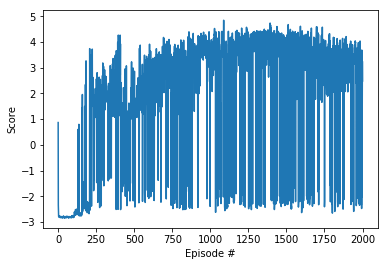

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

start = 1937
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=20000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    with open('E:/Weights_/pickle/' + str(start), "rb") as file:
        agent.memory = pickle.load(file)
        total_scores = pickle.load(file)
        success = pickle.load(file)

    print("memory: {}, total_scores: {}, success: {}".format(len(agent.memory.buffer), len(total_scores), success))
    
    for ep in range(start+1, TRAINING_EPISODES+1):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0
        RX = None
        RY = None
        RS = None
        RYAW = None

        start=time.time()
        client.simPause(True)
        state = EnvGetState(client)

        while True:          
            action = agent.act(state, True)                        
            reward, next_state, done, flag = EnvStep(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs)                        
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f} L: {:.4f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), flag, success, np.mean(t), np.mean(s), np.mean(agent.critic_loss), step))

        if np.mean(total_scores[-100:]) >= 4.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep, np.mean(total_scores[-100:])))
            saver.save(sess, save_file, global_step=ep)  
            break

        saver.save(sess, save_file, global_step=ep)
        with open('E:/Weights_/pickle/' + str(ep), 'wb') as file:        
            pickle.dump(agent.memory, file)
            pickle.dump(total_scores, file)
            pickle.dump(success, file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

# Print scores

memory: 859101, total_scores: 2000, success: 1085
Max: 3.567256034053802, index: 1028, len: 2000
-3.2282303606987
5.232102511882784


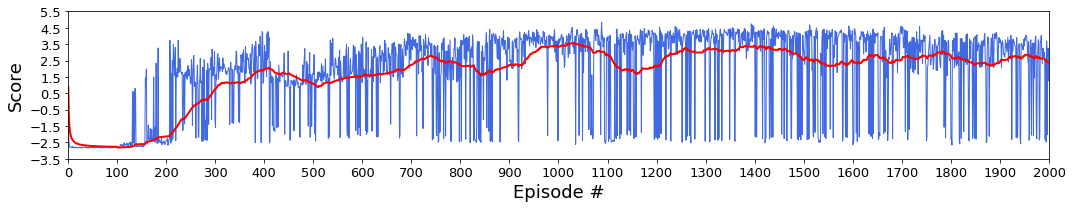

In [56]:
memory = None
start = 2000
total_scores = []
success = 0

with open('E:/Weights_/pickle/' + str(start), "rb") as file:
    memory = pickle.load(file)
    total_scores = pickle.load(file)
    success = pickle.load(file)

print("memory: {}, total_scores: {}, success: {}".format(len(memory.buffer), len(total_scores), success))
temp = []
average_scores = []
for i in range(2000):    
    temp.append(total_scores[i])
    average_scores.append(np.mean(temp[-100:]))
print("Max: {}, index: {}, len: {}".format(max(average_scores), average_scores.index(max(average_scores))+1, len(average_scores)))

fig = plt.figure(figsize=(15,3))
plot = fig.add_subplot(111)
plot.tick_params(axis='both', labelsize=13)

plt.plot(np.arange(1, len(total_scores)+1), total_scores, color="royalblue", lw=1, ls="-", marker=None)
plt.plot(np.arange(1, len(total_scores)+1), average_scores, color="r", lw=2, ls="-", marker=None)
plt.xlim(0, 2000)
ax = plt.gca()
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start , end+1, 100))
ystart, yend = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(-3.5, 5.6, 1))
print(ystart)
print(yend)
plt.ylabel('Score', fontsize=18)
plt.xlabel('Episode #', fontsize=18)
plt.tight_layout()
plt.savefig('E:/Weights_/score_average_2000.png', dpi=1000, format="png")
plt.show()   

# Evaluation

Connected!
Client Ver:1 (Min Req: 1), Server Ver:1 (Min Req: 1)

INFO:tensorflow:Restoring parameters from model/lane_change-1030
Ep:    1 HV: 12.8 RV: 16.1 Score:  3.600 Average:  3.600 Max: 3.60 Min: 3.60 F:7 S:   1, Th: 0.78 Steer:  0.00, step: 500
Ep:    2 HV: 13.2 RV: 19.0 Score:  3.985 Average:  3.793 Max: 3.99 Min: 3.60 F:7 S:   2, Th: 0.82 Steer: -0.00, step: 500
Ep:    3 HV: 13.3 RV: 18.3 Score:  3.795 Average:  3.793 Max: 3.99 Min: 3.60 F:7 S:   3, Th: 0.79 Steer:  0.00, step: 500
Ep:    4 HV: 12.9 RV: 16.1 Score:  3.586 Average:  3.741 Max: 3.99 Min: 3.59 F:7 S:   4, Th: 0.75 Steer: -0.01, step: 500
Ep:    5 HV: 13.2 RV: 17.5 Score:  3.796 Average:  3.752 Max: 3.99 Min: 3.59 F:7 S:   5, Th: 0.78 Steer:  0.01, step: 500
Ep:    6 HV: 13.2 RV: 17.5 Score:  3.802 Average:  3.761 Max: 3.99 Min: 3.59 F:7 S:   6, Th: 0.81 Steer:  0.01, step: 500
Ep:    7 HV: 12.9 RV: 15.9 Score:  3.251 Average:  3.688 Max: 3.99 Min: 3.25 F:7 S:   7, Th: 0.76 Steer:  0.00, step: 500
Ep:    8 HV: 13.

Ep:   68 HV: 12.9 RV: 15.9 Score:  2.777 Average:  3.677 Max: 4.08 Min: 2.78 F:7 S:  68, Th: 0.76 Steer: -0.00, step: 500
Ep:   69 HV: 13.1 RV: 17.2 Score:  3.778 Average:  3.678 Max: 4.08 Min: 2.78 F:7 S:  69, Th: 0.78 Steer:  0.01, step: 500
Ep:   70 HV: 13.1 RV: 17.4 Score:  3.788 Average:  3.680 Max: 4.08 Min: 2.78 F:7 S:  70, Th: 0.77 Steer:  0.00, step: 500
Ep:   71 HV: 13.3 RV: 19.0 Score:  3.827 Average:  3.682 Max: 4.08 Min: 2.78 F:7 S:  71, Th: 0.80 Steer:  0.01, step: 500
Ep:   72 HV: 13.0 RV: 17.0 Score:  3.737 Average:  3.682 Max: 4.08 Min: 2.78 F:7 S:  72, Th: 0.79 Steer:  0.01, step: 500
Ep:   73 HV: 12.9 RV: 16.5 Score:  3.697 Average:  3.683 Max: 4.08 Min: 2.78 F:7 S:  73, Th: 0.74 Steer: -0.00, step: 500
Ep:   74 HV: 13.2 RV: 18.4 Score:  3.800 Average:  3.684 Max: 4.08 Min: 2.78 F:7 S:  74, Th: 0.79 Steer:  0.01, step: 500
Ep:   75 HV: 13.2 RV: 18.8 Score:  3.809 Average:  3.686 Max: 4.08 Min: 2.78 F:7 S:  75, Th: 0.79 Steer:  0.01, step: 500
Ep:   76 HV: 13.2 RV: 17

Ep:  136 HV: 13.1 RV: 16.3 Score:  3.454 Average:  3.690 Max: 4.09 Min: 2.78 F:7 S: 136, Th: 0.75 Steer: -0.02, step: 500
Ep:  137 HV: 12.8 RV: 15.9 Score:  3.575 Average:  3.688 Max: 4.09 Min: 2.78 F:7 S: 137, Th: 0.78 Steer:  0.00, step: 500
Ep:  138 HV: 13.3 RV: 18.5 Score:  3.804 Average:  3.688 Max: 4.09 Min: 2.78 F:7 S: 138, Th: 0.80 Steer:  0.01, step: 500
Ep:  139 HV: 13.4 RV: 19.1 Score:  3.837 Average:  3.688 Max: 4.09 Min: 2.78 F:7 S: 139, Th: 0.82 Steer:  0.01, step: 500
Ep:  140 HV: 13.2 RV: 17.8 Score:  3.820 Average:  3.688 Max: 4.09 Min: 2.78 F:7 S: 140, Th: 0.77 Steer:  0.00, step: 500
Ep:  141 HV: 13.3 RV: 18.0 Score:  3.785 Average:  3.688 Max: 4.09 Min: 2.78 F:7 S: 141, Th: 0.79 Steer:  0.01, step: 500
Ep:  142 HV: 13.1 RV: 17.3 Score:  3.784 Average:  3.688 Max: 4.09 Min: 2.78 F:7 S: 142, Th: 0.79 Steer:  0.00, step: 500
Ep:  143 HV: 13.0 RV: 15.8 Score:  3.326 Average:  3.683 Max: 4.09 Min: 2.78 F:7 S: 143, Th: 0.76 Steer: -0.01, step: 500
Ep:  144 HV: 13.1 RV: 17

Ep:  204 HV: 13.3 RV: 18.9 Score:  3.820 Average:  3.701 Max: 4.09 Min: 2.78 F:7 S: 204, Th: 0.79 Steer:  0.01, step: 500
Ep:  205 HV: 13.3 RV: 18.4 Score:  3.826 Average:  3.701 Max: 4.09 Min: 2.78 F:7 S: 205, Th: 0.80 Steer:  0.01, step: 500
Ep:  206 HV: 13.1 RV: 17.3 Score:  3.796 Average:  3.702 Max: 4.09 Min: 2.78 F:7 S: 206, Th: 0.77 Steer:  0.01, step: 500
Ep:  207 HV: 13.3 RV: 18.1 Score:  3.812 Average:  3.706 Max: 4.09 Min: 2.78 F:7 S: 207, Th: 0.79 Steer:  0.01, step: 500
Ep:  208 HV: 12.7 RV: 15.7 Score:  2.892 Average:  3.697 Max: 4.09 Min: 2.78 F:7 S: 208, Th: 0.78 Steer:  0.00, step: 500
Ep:  209 HV: 13.2 RV: 18.1 Score:  3.830 Average:  3.706 Max: 4.09 Min: 2.78 F:7 S: 209, Th: 0.78 Steer:  0.00, step: 500
Ep:  210 HV: 13.0 RV: 16.9 Score:  3.729 Average:  3.705 Max: 4.09 Min: 2.78 F:7 S: 210, Th: 0.78 Steer:  0.00, step: 500
Ep:  211 HV: 13.1 RV: 17.1 Score:  3.778 Average:  3.705 Max: 4.09 Min: 2.78 F:7 S: 211, Th: 0.77 Steer:  0.01, step: 500
Ep:  212 HV: 13.2 RV: 18

Ep:  272 HV: 13.2 RV: 19.0 Score:  3.804 Average:  3.691 Max: 4.09 Min: 2.69 F:7 S: 272, Th: 0.79 Steer:  0.00, step: 500
Ep:  273 HV: 13.3 RV: 18.6 Score:  3.834 Average:  3.692 Max: 4.09 Min: 2.69 F:7 S: 273, Th: 0.79 Steer:  0.01, step: 500
Ep:  274 HV: 13.1 RV: 16.9 Score:  3.755 Average:  3.692 Max: 4.09 Min: 2.69 F:7 S: 274, Th: 0.75 Steer:  0.01, step: 500
Ep:  275 HV: 13.2 RV: 17.2 Score:  3.817 Average:  3.695 Max: 4.09 Min: 2.69 F:7 S: 275, Th: 0.77 Steer:  0.01, step: 500
Ep:  276 HV: 13.0 RV: 16.9 Score:  3.737 Average:  3.699 Max: 4.09 Min: 2.69 F:7 S: 276, Th: 0.76 Steer:  0.01, step: 500
Ep:  277 HV: 13.0 RV: 16.9 Score:  3.728 Average:  3.698 Max: 4.09 Min: 2.69 F:7 S: 277, Th: 0.76 Steer:  0.01, step: 500
Ep:  278 HV: 13.3 RV: 18.9 Score:  3.822 Average:  3.698 Max: 4.09 Min: 2.69 F:7 S: 278, Th: 0.79 Steer:  0.01, step: 500
Ep:  279 HV: 13.0 RV: 16.7 Score:  3.716 Average:  3.697 Max: 4.09 Min: 2.69 F:7 S: 279, Th: 0.76 Steer:  0.01, step: 500
Ep:  280 HV: 12.9 RV: 16

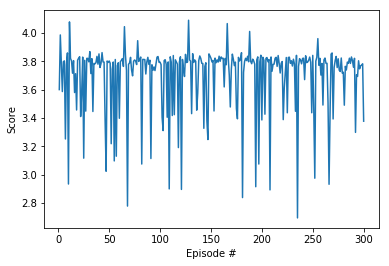

Max: 4.09 index: 128
[[30.63656234741211, 3.4056665036827325], [30.821210861206055, 3.405759277381003], [31.006601333618164, 3.4056201168335973], [31.192655563354492, 3.4050708008930086], [31.379451751708984, 3.40396728515625], [31.566951751708984, 3.4021826170850544], [31.755077362060547, 3.3996044921863358], [31.943866729736328, 3.396118164155632], [32.13328170776367, 3.391613769903779], [32.323320388793945, 3.3859863286837935], [32.51398468017578, 3.3791235364973544], [32.705156326293945, 3.370910646021366], [32.89683532714844, 3.36124267578125], [33.08921813964844, 3.350524903833866], [33.282264709472656, 3.3391162134706973], [33.47601509094238, 3.3273144528269767], [33.670467376708984, 3.315371097624302], [33.86562538146973, 3.3035009816288947], [34.061561584472656, 3.291899414360523], [34.25816345214844, 3.2805688470602035], [34.45550727844238, 3.269555667042732], [34.65351486206055, 3.258937993645668], [34.85222625732422, 3.2488110452890395], [35.051639556884766, 3.2392944335937

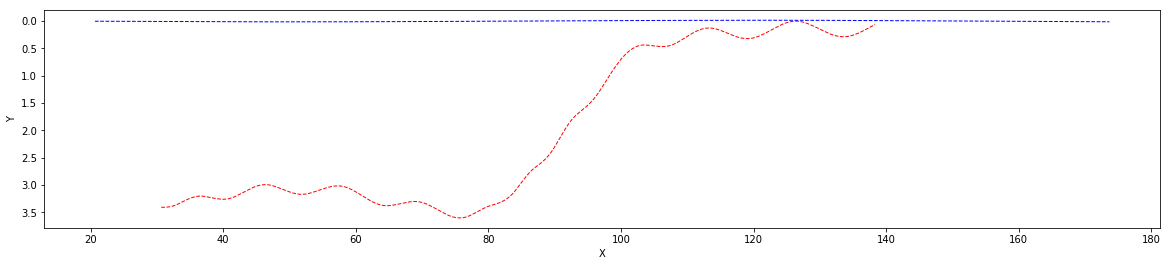

Min: 2.69 index: 235
[[29.54960823059082, 3.4051025389693677], [29.72980499267578, 3.40518798828125], [29.910741806030273, 3.405036620888859], [30.092382431030273, 3.4044604493305086], [30.274765014648438, 3.403312988206744], [30.45785140991211, 3.401467285095714], [30.64156150817871, 3.398803710914217], [30.825937271118164, 3.3952148436568677], [31.010976791381836, 3.3905859380960464], [31.196640014648438, 3.3848071290180086], [31.382850646972656, 3.3777685552835464], [31.56964874267578, 3.3693579114973544], [31.75699234008789, 3.3594628922641276], [31.94495964050293, 3.348510743677616], [32.13359260559082, 3.3368725568056106], [32.322967529296875, 3.324858398735523], [32.51304626464844, 3.3127270504832267], [32.703866958618164, 3.3006982445716857], [32.895389556884766, 3.288972170650959], [33.087615966796875, 3.2775488287210464], [33.28058624267578, 3.266464853286743], [33.47421836853027, 3.255795904994011], [33.66855430603027, 3.245632329583168], [33.86371040344238, 3.23608154952526

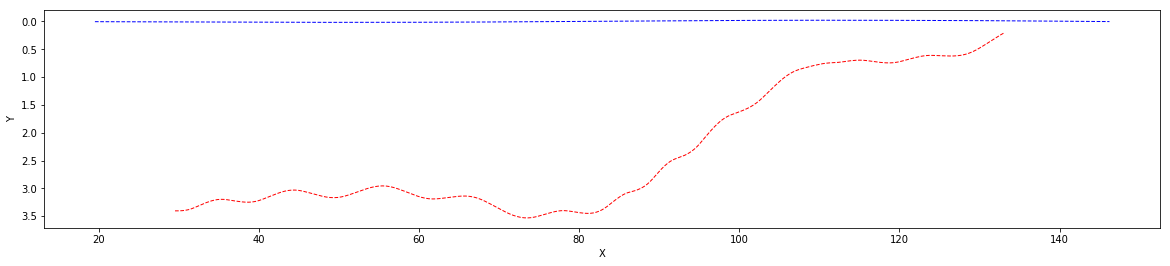

In [7]:
client = airsim.CarClient()

client.confirmConnection()
client.enableApiControl(True, "Host")
client.enableApiControl(True, "Remote")

host_control = airsim.CarControls()
remote_control = airsim.CarControls()

tf.reset_default_graph()
with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, TAU)

#start = 1028
start = 1030
save_file = "model/lane_change"
saver = tf.train.Saver(max_to_keep=10000)

total_scores = []
success = 0

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    saver.restore(sess, save_file + "-" + str(start))
    agent.set_session(sess)    
    
    for ep in range(1, 301):
        time.sleep(1)
        while True:        
            if client.getCarState("Host").speed >= 11.11:
                break
            goStraight("Host", client, host_control)
            goStraight("Remote", client, remote_control)
            time.sleep(0.1)

        host_control.throttle = 0.70        
        client.setCarControls(host_control, "Host")                

        agent.reset()
        target_speed = 16.67 + np.random.rand(1)[0] * 5.55
        score = 0
        t = []
        s = []
        hvs = []
        rvs = []
        step = 0        
        RX = None
        RY = None
        RS = None
        RYAW = None
        host_position = []
        remote_position = []

        start=time.time()
        client.simPause(True)
        state = EnvGetStateForEvalution(client, host_position, remote_position)
        while True:          
            action = agent.act(state, False)                        
            reward, state, done, flag = EnvStepForEvaluation(start, client, action, host_control, remote_control, target_speed, t, s, hvs, rvs, host_position, remote_position)                                    
            score += reward

            if done:
                if flag == 7:
                    success += 1
                client.reset()
                time.sleep(1)
                client.simPause(False)
                break

        total_scores.append(score)
        #episode, score, max_score, min_score
        print("Ep: {:4d} HV: {:4.1f} RV: {:4.1f} Score: {:6.3f} Average: {:6.3f} Max: {:4.2f} Min: {:4.2f} F:{} S:{:4d}, Th: {:3.2f} Steer: {:5.2f}, step: {}"
              .format(ep, np.mean(hvs), np.mean(rvs), score, np.mean(total_scores[-100:]), np.max(total_scores), np.min(total_scores), flag, success, np.mean(t), np.mean(s), step))
        with open('E:/Weights_/position/' + str(ep), 'wb') as file:                    
            pickle.dump(host_position, file)
            pickle.dump(remote_position, file)
            
        
print("Success: {}%".format(success / 300.0 * 100.0))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

print("Max: {:4.2f} index: {}".format(np.max(total_scores), total_scores.index(np.max(total_scores))+1))
with open('E:/Weights_/position/' + str(total_scores.index(np.max(total_scores))+1), 'rb') as file:                    
    host_position = pickle.load(file)
    remote_position = pickle.load(file)
    print(host_position)

    host_x = []
    host_y = []
    for p in host_position:
        host_x.append(p[0])
        host_y.append(p[1])
    remote_x = []
    remote_y = []
    for p in remote_position:
        remote_x.append(p[0])
        remote_y.append(p[1])
    fig = plt.figure(figsize=(20,4))    
    plt.plot(host_x, host_y, color="red", lw=1, ls="dashed", marker=None)
    plt.plot(remote_x, remote_y, color="blue", lw=1, ls="dashed", marker=None)
    plt.ylabel('Y')
    plt.xlabel('X')
    plt.gca().invert_yaxis()    
    plt.savefig('E:/Weights_/position/max_' + str(total_scores.index(np.max(total_scores))+1) + '.png', dpi=1000, format="png")
    plt.show()  
    
print("Min: {:4.2f} index: {}".format(np.min(total_scores), total_scores.index(np.min(total_scores))+1))
with open('E:/Weights_/position/' + str(total_scores.index(np.min(total_scores))+1), 'rb') as file:                    
    host_position = pickle.load(file)
    remote_position = pickle.load(file)
    print(host_position)

    host_x = []
    host_y = []
    for p in host_position:
        host_x.append(p[0])
        host_y.append(p[1])
    remote_x = []
    remote_y = []
    for p in remote_position:
        remote_x.append(p[0])
        remote_y.append(p[1])
    fig = plt.figure(figsize=(20,4))    
    plt.plot(host_x, host_y, color="red", lw=1, ls="dashed", marker=None)
    plt.plot(remote_x, remote_y, color="blue", lw=1, ls="dashed", marker=None)
    plt.ylabel('Y')
    plt.xlabel('X')
    plt.gca().invert_yaxis()    
    plt.savefig('E:/Weights_/position/min_' + str(total_scores.index(np.min(total_scores))+1) + '.png', dpi=1000, format="png")
    plt.show()   